In [8]:
from regvelovi import REGVELOVI

Global seed set to 0
/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [9]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvelo as scv
import sctour as rgv
from velovi import preprocess_data

In [10]:
scv.set_figure_params()

In [11]:
adata = sc.read_h5ad("dataset_branch_v2.h5ad")

In [12]:
def sanity_check(adata):
    reg_index = [i in adata.var.index.values for i in adata.uns["regulators"]]
    tar_index = [i in adata.var.index.values for i in adata.uns["targets"]]
    adata.uns["regulators"] = adata.uns["regulators"][reg_index]
    adata.uns["targets"] = adata.uns["targets"][tar_index]
    W = adata.uns["skeleton"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["skeleton"] = W
    W = adata.uns["network"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["network"] = W
    
    regulators = adata.uns["regulators"][adata.uns["skeleton"].sum(1) > 0]
    targets = adata.uns["targets"][adata.uns["skeleton"].sum(0) > 0]
    
    adata = adata[:,np.unique(regulators.tolist()+targets.tolist())].copy()
    
    ## to make sure consistency
    regulator_index = [i in regulators for i in adata.var.index.values]
    target_index = [i in targets for i in adata.var.index.values]
    regulators = adata.var.index.values[regulator_index]
    targets = adata.var.index.values[target_index]
    print("num regulators: "+str(len(regulators)))
    print("num targets: "+str(len(targets)))
    
    W = pd.DataFrame(adata.uns["skeleton"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["skeleton"] = W
    W = pd.DataFrame(adata.uns["network"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["network"] = W
    
    adata.uns["regulators"] = regulators
    adata.uns["targets"] = targets
    
    return adata

In [13]:
adata.uns["skeleton"].shape

(280, 280)

In [14]:
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()

In [15]:
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=280)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 14 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [16]:
adata.layers["Ms"].max()

39747.324

In [17]:
adata.X = np.log1p(adata.X.copy())

In [18]:
adata = preprocess_data(adata)
adata = sanity_check(adata)
adata.uns["Ms"] = adata.layers["Ms"]
adata.uns["Mu"] = adata.layers["Mu"]

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 88
num targets: 133


In [19]:
import torch
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

In [20]:
W.shape

torch.Size([88, 133])

In [56]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(adata,W=W.T)

In [57]:
reg_vae.module.v_encoder.grn.data

tensor([[-0.7480, -0.0000, -0.6988,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000, -0.7035,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [58]:
coef = np.array(reg_vae.module.v_encoder.grn.data).ravel()
coef = coef[coef!=0]
coef = np.abs(coef)
coef = pd.DataFrame({"coef":coef})

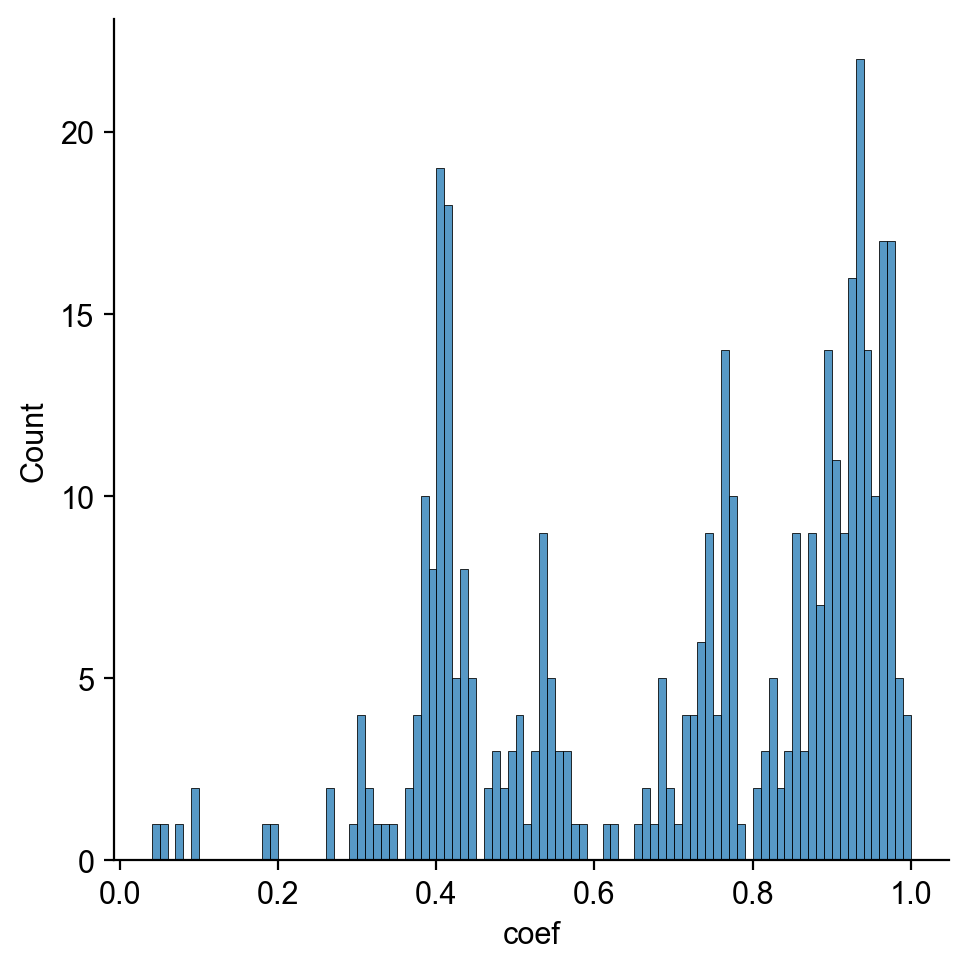

In [59]:
import seaborn as sns
sns.displot(coef, x="coef", binwidth=0.01)

In [60]:
reg_vae.module.alpha_1_unconstr

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)

In [61]:
reg_vae.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])

In [62]:
reg_vae.module.dirichlet_concentration

tensor([0.8000, 0.1000, 0.1000])

In [63]:
reg_vae.module.v_encoder.alpha_unconstr_bias

Parameter containing:
tensor([0.2837, 0.3349, 0.4678, 0.0175, 0.4040, 0.3680, 0.4183, 0.3693, 0.3043,
        0.4052, 0.4751, 0.4462, 0.4470, 0.4189, 0.4169, 0.5017, 0.4129, 0.4602,
        0.4169, 0.4801, 0.4721, 0.4369, 0.4919, 0.3943, 0.4950, 0.4681, 0.4105,
        0.4673, 0.4862, 0.4699, 0.4875, 0.4375, 0.2296, 0.4422, 0.3303, 0.5031,
        0.3417, 0.4225, 0.3829, 0.3684, 0.4063, 0.3868, 0.4212, 0.4071, 0.4460,
        0.4173, 0.4596, 0.3101, 0.4275, 0.3168, 0.4852, 0.4858, 0.3787, 0.5065,
        0.4598, 0.4485, 0.4762, 0.5033, 0.3864, 0.4375, 0.2525, 0.3609, 0.4121,
        0.2830, 0.2591, 0.4056, 0.4220, 0.4145, 0.4183, 0.4791, 0.4869, 0.4208,
        0.3835, 0.3845, 0.4808, 0.2246, 0.4352, 0.4272, 0.4049, 0.2792, 0.2199,
        0.2697, 0.4384, 0.2978, 0.4583, 0.3149, 0.4215, 0.2221, 0.3554, 0.1695,
        0.4504, 0.3040, 0.4098, 0.4145, 0.4269, 0.3463, 0.4876, 0.4190, 0.2121,
        0.2435, 0.1957, 0.2750, 0.3196, 0.2718, 0.4824, 0.3453, 0.4284, 0.2497,
        0.4257, 0.

In [64]:
reg_vae.train(max_epochs=1300,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 170/1300:  13%|██████▏                                        | 170/1300 [02:28<16:27,  1.14it/s, loss=-472, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 2.576. Signaling Trainer to stop.


In [65]:
torch.abs(reg_vae.module.v_encoder.grn).sum()

tensor(181.0896, grad_fn=<SumBackward0>)

In [66]:
reg_vae.history.keys()

dict_keys(['validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'kl_weight', 'train_loss_step'])

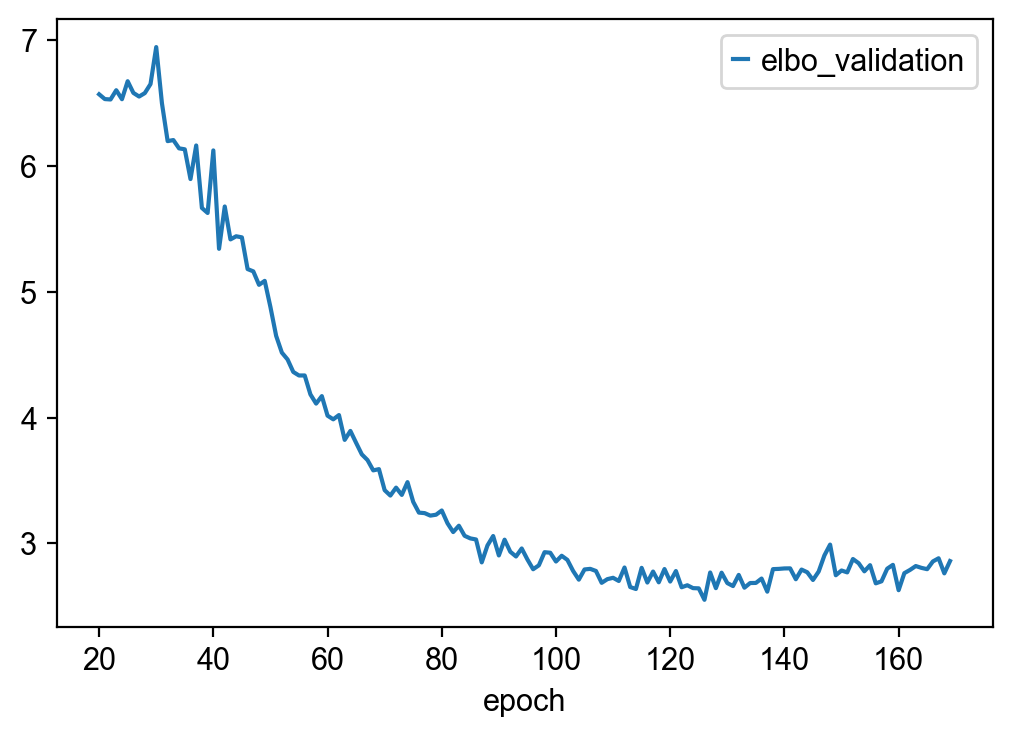

In [68]:
fig, ax = plt.subplots()
reg_vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="train_loss_epoch")
plt.legend()

In [69]:
sum(p.pow(2.0).sum() for p in reg_vae.module.v_encoder.grn)

tensor(107.0801, grad_fn=<AddBackward0>)

In [70]:
def add_velovi_outputs_to_adata(adata_raw, vae):
    latent_time = vae.get_latent_time(n_samples=25, time_statistic = "mean")
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    #adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    #adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    #adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
    return adata

adata_target = add_velovi_outputs_to_adata(adata, reg_vae)

In [71]:
scv.tl.velocity_graph(adata_target)

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing terminal states
    identified 0 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


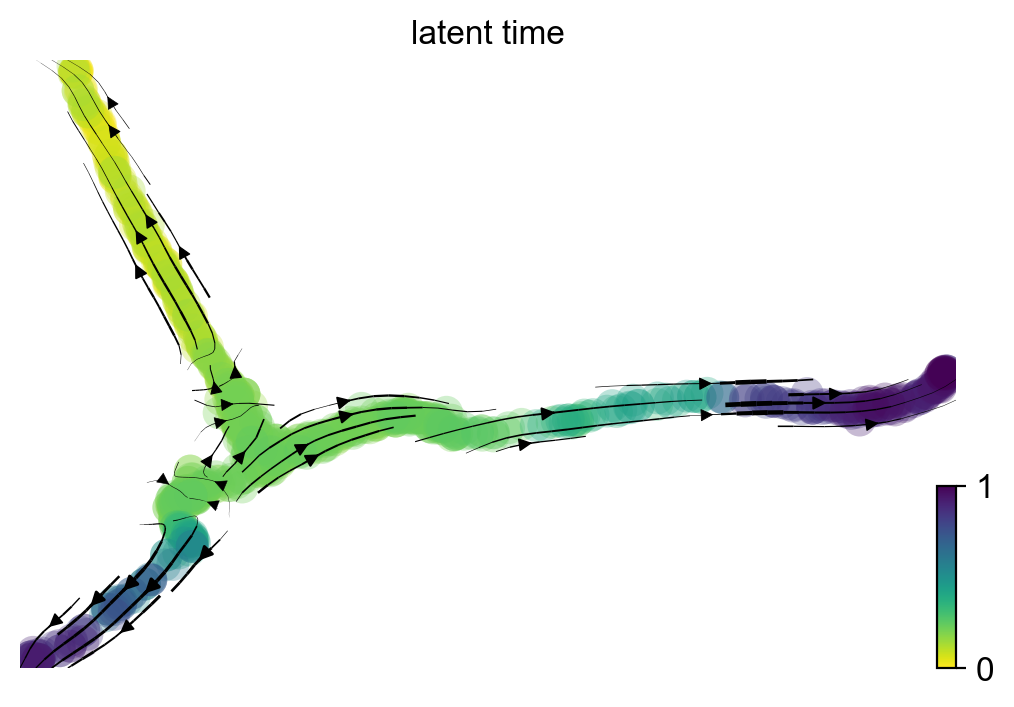

In [72]:
scv.tl.latent_time(adata_target,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata_target, basis='dimred',color = 'latent_time')

In [73]:
import scipy
scipy.stats.spearmanr(adata_target.obs["latent_time"], adata_target.obs["sim_time"])

SignificanceResult(statistic=0.861090235200738, pvalue=2.016828905058101e-295)

In [74]:
velocity_gt = adata_target.layers["rna_velocity"]
velocity = adata_target.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:133,133:(133*2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

corr = np.array(corr)[:,0]

In [75]:
adata_target.layers["rna_velocity"].max()

9.66399654745004

In [76]:
corr.mean()

0.1959647557414242

In [78]:
velocity_regvelovi = velocity.copy()
corr_regvelovi = corr.copy()

In [79]:
GRN = W.T * reg_vae.module.v_encoder.grn

In [80]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"].T)==1]

In [81]:
pre = GRN[W.T==1]

In [82]:
from scipy.spatial.distance import cdist
regulator_index = [i in adata.uns["regulators"] for i in adata.var.index.values]
target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
        
corr_m = 1 - cdist(adata.X.todense().T, adata.X.todense().T, metric='correlation')
corr_m = torch.tensor(corr_m)
corr_m = corr_m[target_index,]
corr_m = corr_m[:,regulator_index]
corr_m = corr_m.float()

In [83]:
pre2 = corr_m[np.array(adata.uns["skeleton"].T)==1]

In [84]:
import scipy.stats as stats

# calculate Spearman correlation coefficient and p-value
corr, _ = stats.spearmanr(np.abs(pre.detach().numpy()),np.abs(gt))
corr

0.508156681611352

In [98]:
reg_vae.module.v_encoder.grn

Parameter containing:
tensor([[-0.6065, -0.0000, -0.5554,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000, -0.5592,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [101]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae2 = REGVELOVI(adata,W=W.T)

In [102]:
GRN = torch.tensor(np.log1p(celloracle_m)) * torch.sign(reg_vae2.module.v_encoder.grn.data)
GRN = GRN.float()
GRN
reg_vae2.module.v_encoder.grn.data = GRN

In [103]:
reg_vae2.module.v_encoder.grn

Parameter containing:
tensor([[-2.8801,  0.0000, -2.7610,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -2.7379,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [104]:
reg_vae2.module.alpha_1_unconstr

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)

In [105]:
reg_vae2.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])

In [106]:
reg_vae2.module.dirichlet_concentration

tensor([0.8000, 0.1000, 0.1000])

In [107]:
reg_vae2.module.v_encoder.alpha_unconstr_bias

Parameter containing:
tensor([0.2837, 0.3349, 0.4678, 0.0175, 0.4040, 0.3680, 0.4183, 0.3693, 0.3043,
        0.4052, 0.4751, 0.4462, 0.4470, 0.4189, 0.4169, 0.5017, 0.4129, 0.4602,
        0.4169, 0.4801, 0.4721, 0.4369, 0.4919, 0.3943, 0.4950, 0.4681, 0.4105,
        0.4673, 0.4862, 0.4699, 0.4875, 0.4375, 0.2296, 0.4422, 0.3303, 0.5031,
        0.3417, 0.4225, 0.3829, 0.3684, 0.4063, 0.3868, 0.4212, 0.4071, 0.4460,
        0.4173, 0.4596, 0.3101, 0.4275, 0.3168, 0.4852, 0.4858, 0.3787, 0.5065,
        0.4598, 0.4485, 0.4762, 0.5033, 0.3864, 0.4375, 0.2525, 0.3609, 0.4121,
        0.2830, 0.2591, 0.4056, 0.4220, 0.4145, 0.4183, 0.4791, 0.4869, 0.4208,
        0.3835, 0.3845, 0.4808, 0.2246, 0.4352, 0.4272, 0.4049, 0.2792, 0.2199,
        0.2697, 0.4384, 0.2978, 0.4583, 0.3149, 0.4215, 0.2221, 0.3554, 0.1695,
        0.4504, 0.3040, 0.4098, 0.4145, 0.4269, 0.3463, 0.4876, 0.4190, 0.2121,
        0.2435, 0.1957, 0.2750, 0.3196, 0.2718, 0.4824, 0.3453, 0.4284, 0.2497,
        0.4257, 0.

In [108]:
reg_vae2.train(max_epochs=500,lr=0.01,optimizer = "AdamW",weight_decay = 1e-05)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 198/500:  40%|███████████████████▍                             | 198/500 [02:34<03:55,  1.28it/s, loss=-434, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 2.607. Signaling Trainer to stop.


In [109]:
torch.abs(reg_vae2.module.v_encoder.grn).sum()

tensor(641.3273, grad_fn=<SumBackward0>)

In [110]:
reg_vae2.history['elbo_validation'].size

198

In [111]:
fig, ax = plt.subplots()
reg_vae2.history["elbo_train"].iloc[20:].plot(ax=ax, label="reconstruction_emulator_train")
reg_vae2.history["elbo_validation"].iloc[20:].plot(ax=ax, label="reconstruction_emulator_validation")
plt.legend()

In [112]:
sum(p.pow(2.0).sum() for p in reg_vae.module.v_encoder.grn)

tensor(215.9139, grad_fn=<AddBackward0>)

In [113]:
def add_velovi_outputs_to_adata(adata_raw, vae):
    latent_time = vae.get_latent_time(n_samples=25, time_statistic = "mean")
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    #adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    #adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    #adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
    return adata

adata_target = add_velovi_outputs_to_adata(adata, reg_vae2)

In [114]:
scv.tl.velocity_graph(adata_target)

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [115]:
scv.tl.latent_time(adata_target,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata_target, basis='dimred',color = 'latent_time')

computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


In [116]:
import scipy
scipy.stats.spearmanr(adata_target.obs["latent_time"], adata_target.obs["sim_time"])

SignificanceResult(statistic=0.8475771202868042, pvalue=7.089782603899704e-277)

In [117]:
velocity_gt = adata_target.layers["rna_velocity"]
velocity = adata_target.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:133,133:(133*2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

corr = np.array(corr)[:,0]

In [118]:
adata_target.layers["rna_velocity"].max()

9.66399654745004

In [119]:
corr.mean()

0.1993624585890576

In [120]:
GRN = W.T * reg_vae2.module.v_encoder.grn

In [121]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"].T)==1]

In [122]:
pre = GRN[W.T==1]

In [123]:
from scipy.spatial.distance import cdist
regulator_index = [i in adata.uns["regulators"] for i in adata.var.index.values]
target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
        
corr_m = 1 - cdist(adata.X.todense().T, adata.X.todense().T, metric='correlation')
corr_m = torch.tensor(corr_m)
corr_m = corr_m[target_index,]
corr_m = corr_m[:,regulator_index]
corr_m = corr_m.float()

In [124]:
pre2 = corr_m[np.array(adata.uns["skeleton"].T)==1]

In [125]:
import scipy.stats as stats

# calculate Spearman correlation coefficient and p-value
corr, _ = stats.spearmanr(np.abs(pre.detach().numpy()),np.abs(gt))
corr

0.525184770420012

In [126]:
reg_vae2.module.v_encoder.grn.ravel()

tensor([-2.5694,  0.0000, -2.4191,  ...,  0.0000,  0.0000,  0.0000],
       grad_fn=<ViewBackward0>)

In [41]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = reg_vae2.module.v_encoder.grn.detach().numpy().ravel(), pos_label = 1) #positive class is 1; negative class is 0
auroc = sklearn.metrics.auc(fpr, tpr)
auroc

0.6248401143760179

In [42]:
auprc = sklearn.metrics.average_precision_score(W.T.ravel(), reg_vae2.module.v_encoder.grn.detach().numpy().ravel())
auprc

0.05882395316144428

In [43]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = corr_m.ravel(), pos_label = 1) #positive class is 1; negative class is 0
auroc = sklearn.metrics.auc(fpr, tpr)
auroc

0.6808473503163835

In [44]:
auprc = sklearn.metrics.average_precision_score(W.T.ravel(), corr_m.ravel())
auprc

0.07205344569090064

### Using VeloVI to benchmark

In [62]:
from velovi import preprocess_data, VELOVI

In [579]:
adata = sc.read_h5ad("dataset_branch_v2.h5ad")
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=280)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
indices = adata_target.var.index.copy()
adata = adata[:,indices].copy()
adata = preprocess_data(adata,filter_on_r2=False)

Filtered out 14 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [154]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:22<00:00,  5.84it/s, loss=-623, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:22<00:00,  6.09it/s, loss=-623, v_num=1]


In [581]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    

add_velovi_outputs_to_adata(adata, vae)

In [582]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


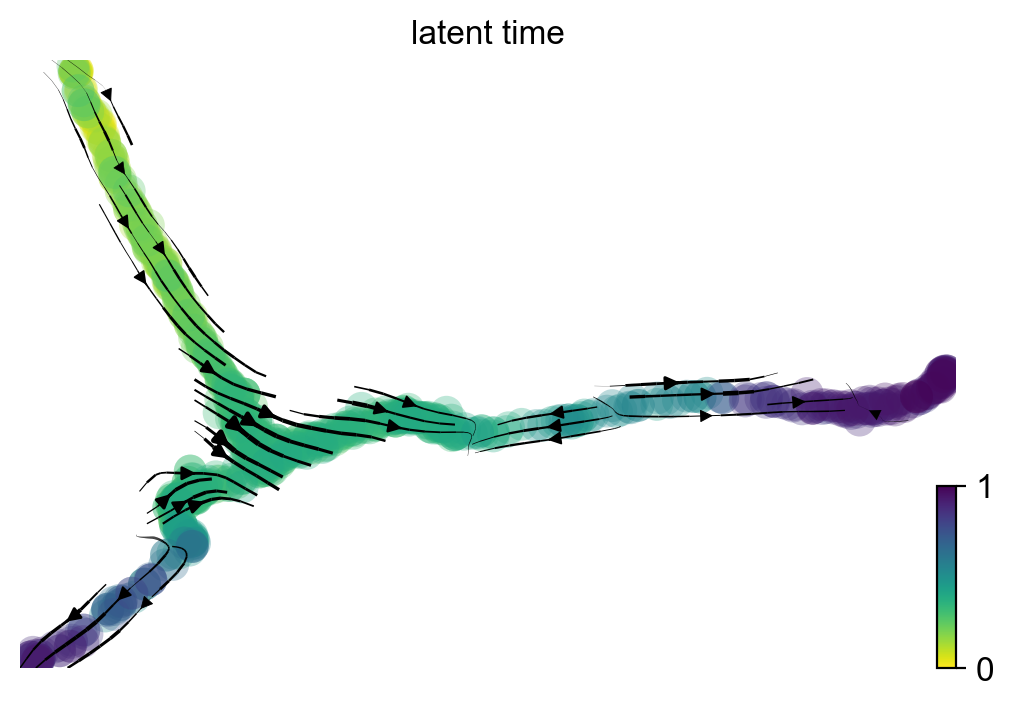

In [583]:
scv.tl.latent_time(adata,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata, basis='dimred',color = 'latent_time')

In [584]:
velocity_gt = adata.layers["rna_velocity"]
velocity = adata.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:133,133:(133*2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

corr = np.array(corr)[:,0]

In [585]:
corr.mean()

0.14854119999924187

In [586]:
import scipy
scipy.stats.spearmanr(adata.obs["latent_time"], adata.obs["sim_time"])

SignificanceResult(statistic=0.830956590572501, pvalue=2.137777823843639e-256)

In [587]:
velocity_velovi = adata.layers["velocity"].copy()
corr_velovi = corr.copy()

## Using Dynamical,Stochastic and Deterministic to perform benchmark

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


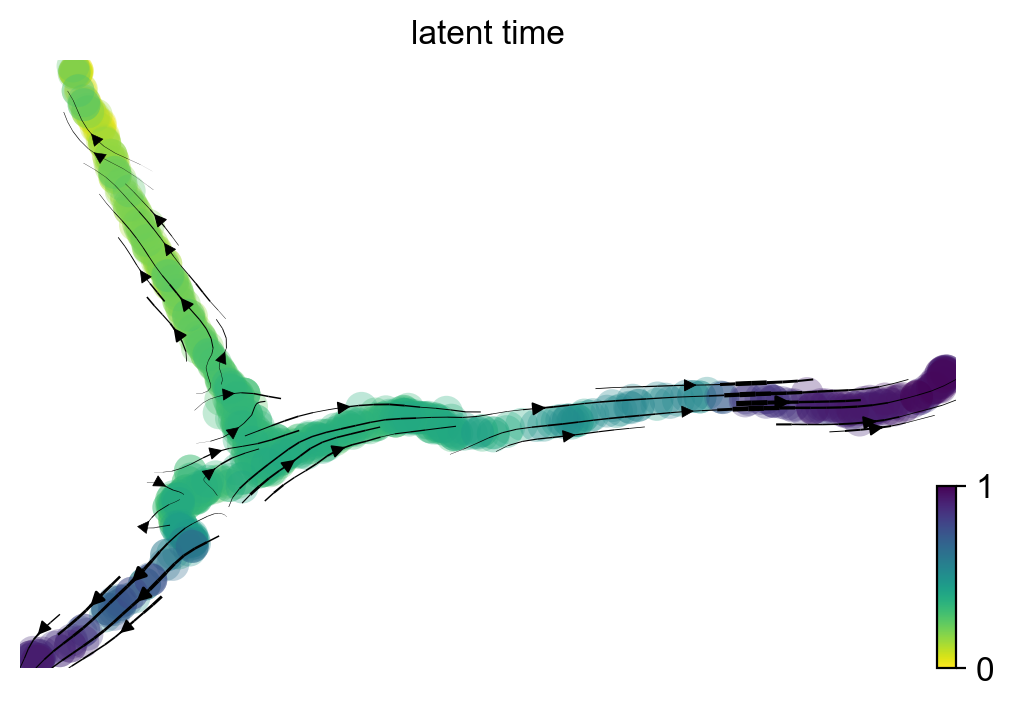

In [588]:
## mode stochastic
scv.tl.velocity(adata, mode = "stochastic")
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis='dimred',color = 'latent_time')

In [589]:
velocity_gt = adata.layers["rna_velocity"]
velocity = adata.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:133,133:(133*2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

corr = np.array(corr)[:,0]

In [590]:
corr.mean()

0.06647468670160839

In [591]:
velocity_stochastic = velocity.copy()
corr_stochastic = corr.copy()

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


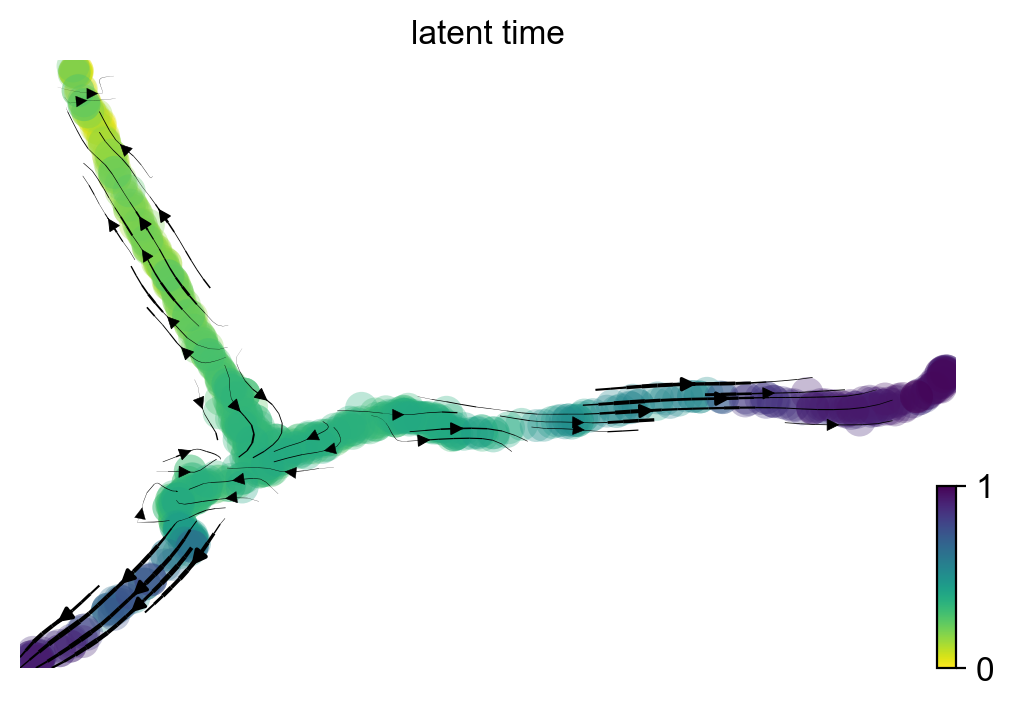

In [592]:
## mode deterministic
scv.tl.velocity(adata, mode = "deterministic")
scv.tl.velocity_graph(adata)
scv.tl.latent_time(adata,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata, basis='dimred',color = 'latent_time')

In [593]:
velocity_gt = adata.layers["rna_velocity"]
velocity = adata.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:133,133:(133*2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

corr = np.array(corr)[:,0]

In [594]:
corr.mean()

0.10754134453958947

In [595]:
velocity_deterministic = velocity.copy()
corr_deteriministic = corr.copy()

recovering dynamics (using 1/8 cores)


  0%|          | 0/133 [00:00<?, ?gene/s]

    finished (0:00:17) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


  0%|          | 0/1000 [00:00<?, ?cells/s]

/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


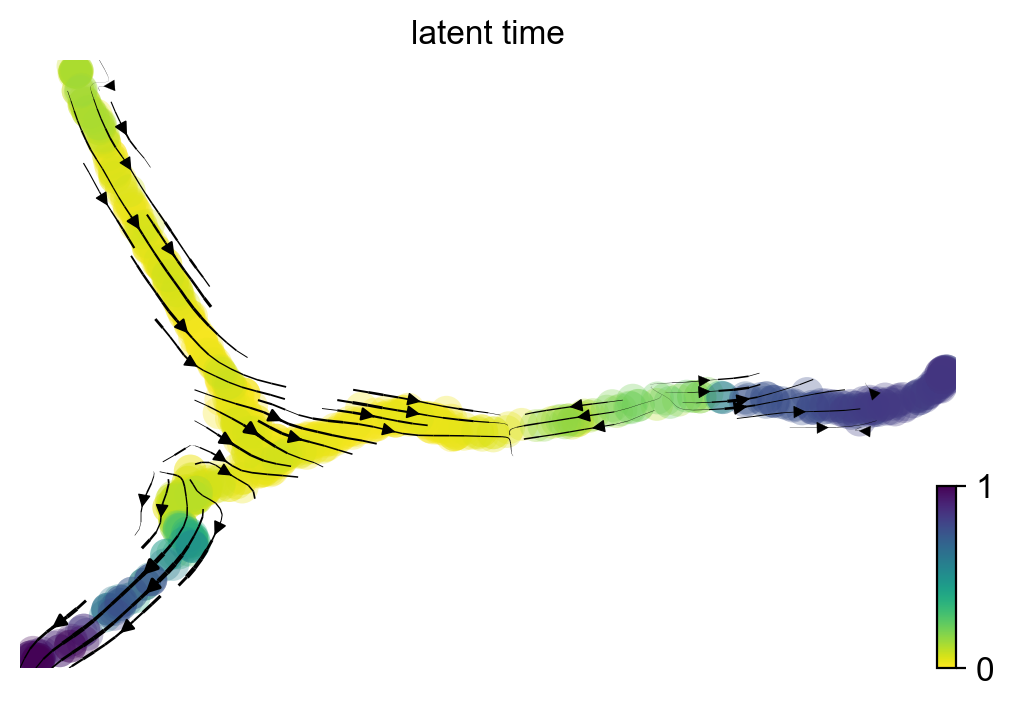

In [596]:
## mode dynamical
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode = "dynamical")
scv.tl.velocity_graph(adata)
scv.tl.latent_time(adata,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata, basis='dimred',color = 'latent_time')

In [597]:
velocity_gt = adata.layers["rna_velocity"]
velocity = adata.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:133,133:(133*2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

corr = np.array(corr)[:,0]

In [598]:
corr.mean()

0.11274853125258967

In [599]:
import scipy
scipy.stats.spearmanr(adata.obs["latent_time"], adata.obs["sim_time"])

SignificanceResult(statistic=0.5628882821614195, pvalue=1.19284494457335e-84)

In [600]:
velocity_dynamics = velocity.copy()
corr_dynamical = corr.copy()

## Visualize velocity benchmark through violin plot

In [472]:
corr_regvelovi = pd.DataFrame(corr_regvelovi).assign(Model="RegVeloVI")
corr_velovi = pd.DataFrame(corr_velovi).assign(Model="VeloVI")
corr_dynamical = pd.DataFrame(corr_dynamical).assign(Model="Dynamical")
corr_stochastic = pd.DataFrame(corr_stochastic).assign(Model="Stochastic")
corr_deteriministic = pd.DataFrame(corr_deteriministic).assign(Model="Deterministic")

cdf = pd.concat([corr_regvelovi,corr_velovi,corr_dynamical,corr_stochastic,corr_deteriministic]) 

In [473]:
mdf = pd.melt(cdf, id_vars=['Model'], var_name=['Number'])

In [474]:
mdf.rename(columns = {'value':'Pearson_Correlation'}, inplace = True)

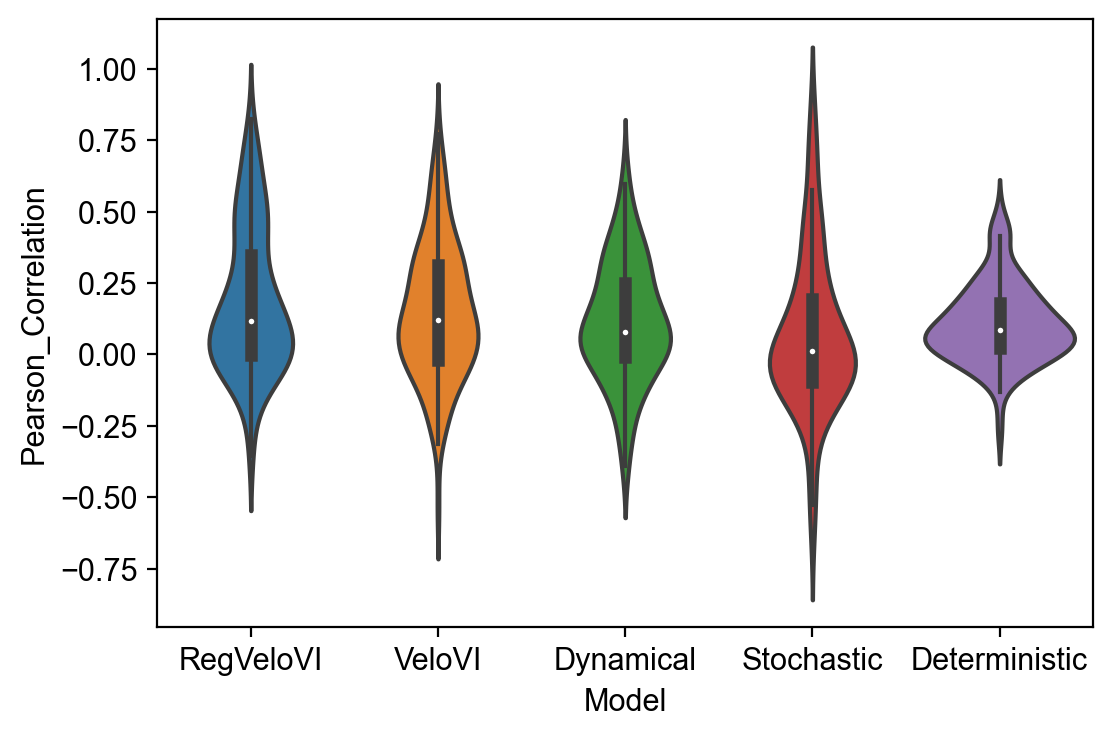

In [475]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.violinplot(x="Model", y="Pearson_Correlation", data=mdf)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [476]:
scipy.stats.wilcoxon(corr_regvelovi.iloc[:,0].values, corr_velovi.iloc[:,0].values)

WilcoxonResult(statistic=3857.0, pvalue=0.17891170509458865)

In [477]:
d = {'Mean_Pearson_Correlation': [corr_regvelovi.iloc[:,0].values.mean(), 
              corr_velovi.iloc[:,0].values.mean(),
              corr_dynamical.iloc[:,0].values.mean(),
              corr_stochastic.iloc[:,0].values.mean(),
              corr_deteriministic.iloc[:,0].values.mean()], 
     'Model': ["RegVeloVI", "VeloVI", "Dynamical", "Stochastic", "Deterministic"]}
df = pd.DataFrame(data=d)

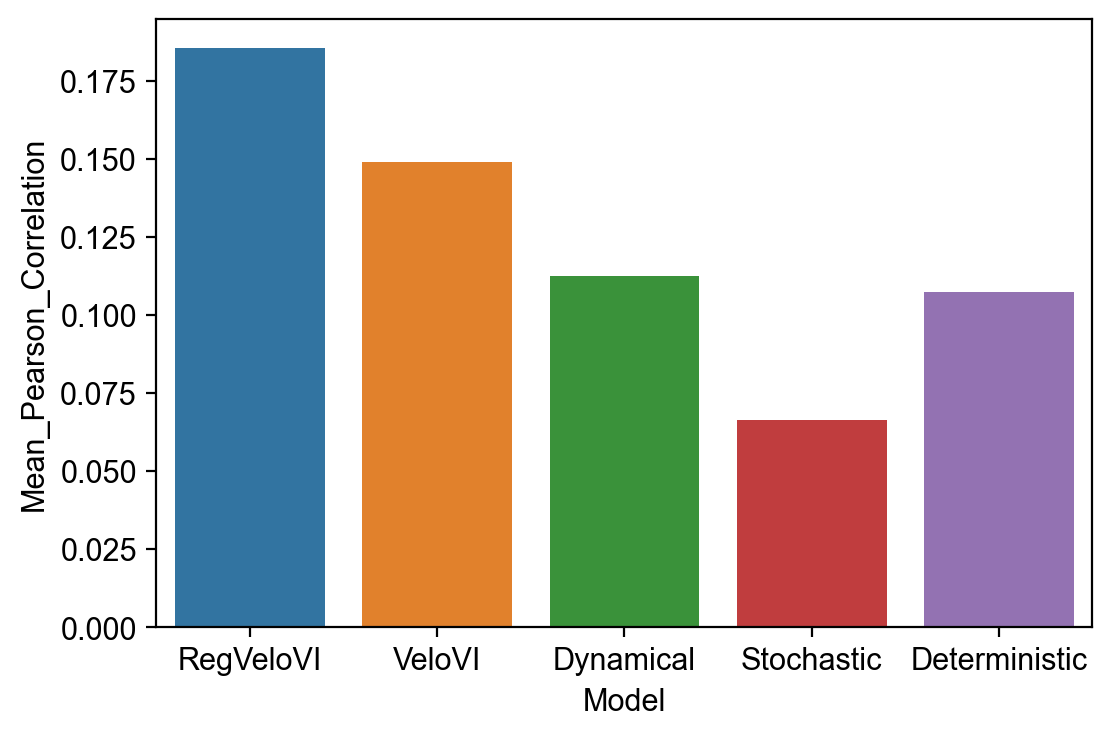

In [478]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(x="Model", y="Mean_Pearson_Correlation", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [479]:
df

,Mean_Pearson_Correlation,Model
0,0.185551,RegVeloVI
1,0.149017,VeloVI
2,0.112749,Dynamical
3,0.066475,Stochastic
4,0.107541,Deterministic


### Using GRNBoost to conduct benchmark

In [15]:
import pandas as pd
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

In [16]:
GEP = pd.DataFrame(adata.layers["Ms"],columns = adata.var.index.values)

In [17]:
network = grnboost2(expression_data=GEP,
                    tf_names=adata.uns["regulators"].tolist())

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


In [18]:
ind = [i in adata.uns["targets"] for i in network["target"]]

In [19]:
network = network[ind]

In [20]:
grnboost_m = np.zeros((len(adata.uns["targets"]),len(adata.uns["regulators"])))
grnboost_m = pd.DataFrame(grnboost_m,index = adata.uns["targets"].tolist(), columns = adata.uns["regulators"].tolist())

In [21]:
for i in adata.uns["targets"]:
    for j in adata.uns["regulators"]:
        ind = (network["TF"] == j) & (network["target"] == i)
        if sum(ind) > 0:
            pdd = network[ind]
            grnboost_m.loc[i,j] = pdd["importance"].values

In [22]:
grnboost_m = np.array(grnboost_m)

In [23]:
grnboost_m.shape

(133, 88)

In [24]:
grn_boost_pre = grnboost_m[np.array(adata.uns["skeleton"]).T==1]

In [25]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"]).T==1]

In [28]:
import scipy
corr, _ = scipy.stats.spearmanr(abs(grn_boost_pre),abs(gt))
corr

0.3660508220205693

In [99]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = grnboost_m.ravel(), pos_label = 1) #positive class is 1; negative class is 0
auroc = sklearn.metrics.auc(fpr, tpr)
auroc

0.7330168734841195

In [100]:
auprc = sklearn.metrics.average_precision_score(W.T.ravel(), grnboost_m.ravel())
auprc

0.08291278911721325

### Using CellOracle to perform benchmark

In [83]:
import celloracle as co
co.__version__

/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/velocyto/neighbors.py:379: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  def make_mutual(knn: sparse.csr.csr_matrix) -> sparse.coo_matrix:
/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/velocyto/neighbors.py:385: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  def connectivity_to_weights(mknn: sparse.csr.csr_matrix, axis: int=1) -> sparse.lil_matrix:
/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pkg_resources/__init__.py:1154: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  return get_provider(package_or_requirement).get_resource_filename(
Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf:

'0.12.0'

In [84]:
### generate base_GRN from the ground truth
target_list = []
for i in range(adata.uns["skeleton"].shape[0]):
    a = list(adata.uns["skeleton"].columns[adata.uns["skeleton"].iloc[i,:] == 1])
    a = ','.join(a)
    target_list.append(a)

In [85]:
d = {"TF":adata.uns["skeleton"].index,"Target_genes":target_list}
df = pd.DataFrame(data=d)

In [86]:
TF_to_TG_dictionary = {}

for TF, TGs in zip(df.TF, df.Target_genes):
    # convert target gene to list
    TG_list = TGs.replace(" ", "").split(",")
    # store target gene list in a dictionary
    TF_to_TG_dictionary[TF] = TG_list

# We invert the dictionary above using a utility function in celloracle.
TG_to_TF_dictionary = co.utility.inverse_dictionary(TF_to_TG_dictionary)

  0%|          | 0/133 [00:00<?, ?it/s]

In [87]:
TG_to_TF_dictionary

{'A4_TF1': ['A3_TF3', 'A3_TF5'],
 'A4_TF3': ['A3_TF5', 'A3_TF6'],
 'A5_TF1': ['A4_TF3'],
 'A6_TF1': ['A5_TF1', 'A5_TF2'],
 'A6_TF2': ['A5_TF1', 'A5_TF2'],
 'A6_TF3': ['A5_TF1', 'A5_TF2'],
 'A6_TF4': ['A5_TF1', 'A5_TF2'],
 'B10_TF1': ['B2_TF1', 'B2_TF2', 'B8_TF1', 'B8_TF3'],
 'B10_TF2': ['B2_TF2', 'B2_TF4', 'B8_TF2', 'B8_TF4'],
 'B11_TF1': ['B2_TF2', 'B2_TF5', 'B8_TF1', 'B8_TF2'],
 'B11_TF2': ['B2_TF4', 'B2_TF5', 'B8_TF1', 'B8_TF4'],
 'B11_TF3': ['B2_TF1', 'B2_TF4', 'B8_TF2', 'B8_TF3'],
 'B11_TF4': ['B2_TF2', 'B2_TF3', 'B8_TF2', 'B8_TF3'],
 'B11_TF5': ['B2_TF4', 'B2_TF5', 'B8_TF4', 'B8_TF5'],
 'B11_TF6': ['B2_TF4', 'B2_TF5', 'B8_TF2', 'B8_TF5'],
 'B11_TF7': ['B2_TF4', 'B2_TF5', 'B8_TF2', 'B8_TF4'],
 'B11_TF8': ['B2_TF2', 'B2_TF3', 'B8_TF2', 'B8_TF4'],
 'B12_TF1': ['B3_TF2', 'B3_TF4', 'B8_TF1', 'B8_TF4'],
 'B12_TF2': ['B3_TF2', 'B3_TF3', 'B8_TF2', 'B8_TF5'],
 'B12_TF3': ['B3_TF1', 'B3_TF2', 'B8_TF4', 'B8_TF5'],
 'B12_TF4': ['B3_TF2', 'B3_TF5', 'B8_TF3', 'B8_TF4'],
 'B13_TF1': ['B3_TF1', 

In [88]:
net = co.Net(gene_expression_matrix=adata.to_df(), # Input gene expression matrix as data frame
             TFinfo_dic=TG_to_TF_dictionary, # Input base GRN
             verbose=True
             )

initiating Net object ...
gem_shape: (1000, 141)
initiation completed.


In [89]:
net.fit_All_genes(bagging_number=20,
                 alpha=10, verbose=True)

  0%|          | 0/133 [00:00<?, ?it/s]

In [90]:
net.updateLinkList(verbose=True)
inference_result = net.linkList.copy()
inference_result

  0%|          | 0/133 [00:00<?, ?it/s]

,source,target,coef_mean,coef_abs,p,-logp
0,A3_TF3,A4_TF1,-1.407456,1.407456,1.525904e-17,16.816473
1,A3_TF5,A4_TF1,-1.303684,1.303684,1.526308e-15,14.816358
2,A3_TF6,A4_TF3,-1.337737,1.337737,6.809426e-16,15.166890
3,A3_TF5,A4_TF3,-1.344407,1.344407,3.508144e-15,14.454923
4,A4_TF3,A5_TF1,-2.385158,2.385158,1.609244e-35,34.793378
...,...,...,...,...,...,...
377,C1_TF5,Target7,0.047278,0.047278,3.121423e-03,2.505647
378,B8_TF4,Target7,0.161176,0.161176,1.041215e-09,8.982460
379,C2_TF2,Target8,-1.110505,1.110505,3.363985e-15,14.473146
380,B8_TF4,Target8,-1.524784,1.524784,3.839550e-17,16.415720


In [94]:
celloracle_m = np.zeros((len(adata.uns["targets"]),len(adata.uns["regulators"])))
celloracle_m = pd.DataFrame(celloracle_m,index = adata.uns["targets"].tolist(), columns = adata.uns["regulators"].tolist())

In [95]:
for i in adata.uns["targets"]:
    for j in adata.uns["regulators"]:
        ind = (inference_result["source"] == j) & (inference_result["target"] == i)
        if sum(ind) > 0:
            pdd = inference_result[ind]
            celloracle_m.loc[i,j] = pdd["-logp"].values

In [96]:
celloracle_m = np.array(celloracle_m)

In [97]:
celloracle_m.shape

(133, 88)

In [98]:
celloracle_pre = celloracle_m[np.array(adata.uns["skeleton"]).T==1]

In [99]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"]).T==1]

In [100]:
corr, _ = stats.spearmanr(np.abs(celloracle_pre),np.abs(gt))
corr

0.3839903815950448

In [826]:
#### using spliced readout to redo the test
adata.X = adata.layers["counts_spliced"].copy()

In [827]:
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')
# Log transformation 
sc.pp.log1p(adata)

In [828]:
net = co.Net(gene_expression_matrix=adata.to_df(), # Input gene expression matrix as data frame
             TFinfo_dic=TG_to_TF_dictionary, # Input base GRN
             verbose=True
             )

initiating Net object ...
gem_shape: (1000, 141)
initiation completed.


In [829]:
net.fit_All_genes(bagging_number=20,
                 alpha=10, verbose=True)

  0%|          | 0/133 [00:00<?, ?it/s]

In [830]:
net.updateLinkList(verbose=True)
inference_result = net.linkList.copy()
inference_result

  0%|          | 0/133 [00:00<?, ?it/s]

,source,target,coef_mean,coef_abs,p,-logp
0,A3_TF5,A4_TF1,-1.270633,1.270633,3.898118e-15,14.409145
1,A3_TF3,A4_TF1,-1.341824,1.341824,2.324203e-16,15.633726
2,A3_TF5,A4_TF3,-1.254087,1.254087,5.687045e-16,15.245113
3,A3_TF6,A4_TF3,-1.225692,1.225692,1.783772e-15,14.748661
4,A4_TF3,A5_TF1,-2.188960,2.188960,3.209789e-34,33.493524
...,...,...,...,...,...,...
377,C1_TF5,Target7,-0.171281,0.171281,3.394295e-07,6.469250
378,B8_TF4,Target7,-0.068206,0.068206,7.056627e-06,5.151403
379,C2_TF2,Target8,-1.366446,1.366446,7.063678e-17,16.150969
380,B8_TF4,Target8,-1.843355,1.843355,2.768405e-17,16.557770


In [839]:
celloracle_m = np.zeros((len(adata.uns["targets"]),len(adata.uns["regulators"])))
celloracle_m = pd.DataFrame(celloracle_m,index = adata.uns["targets"].tolist(), columns = adata.uns["regulators"].tolist())

In [840]:
for i in adata.uns["targets"]:
    for j in adata.uns["regulators"]:
        ind = (inference_result["source"] == j) & (inference_result["target"] == i)
        if sum(ind) > 0:
            pdd = inference_result[ind]
            celloracle_m.loc[i,j] = pdd["coef_mean"].values

In [841]:
celloracle_m = np.array(celloracle_m)

In [842]:
celloracle_m.shape

(133, 88)

In [843]:
celloracle_pre = celloracle_m[np.array(adata.uns["skeleton"]).T==1]

In [844]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"]).T==1]

In [845]:
corr, _ = stats.spearmanr(np.abs(celloracle_pre),np.abs(gt))
corr

0.3388070605151547

In [847]:
sum(np.sign(celloracle_pre)*np.sign(gt) == 1)/len(gt)

0.9015544041450777

### Using CellRank to manually set terminal state and benchmark the fate probability prediction

In [681]:
### preprocessing the data and perform clustering
adata = sc.read_h5ad("dataset_branch_v2.h5ad")
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=280)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.leiden(adata)

Filtered out 14 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.


In [682]:
adata.obsm["X_dimred"] = adata.obsm["dimred"][:,:2].copy()

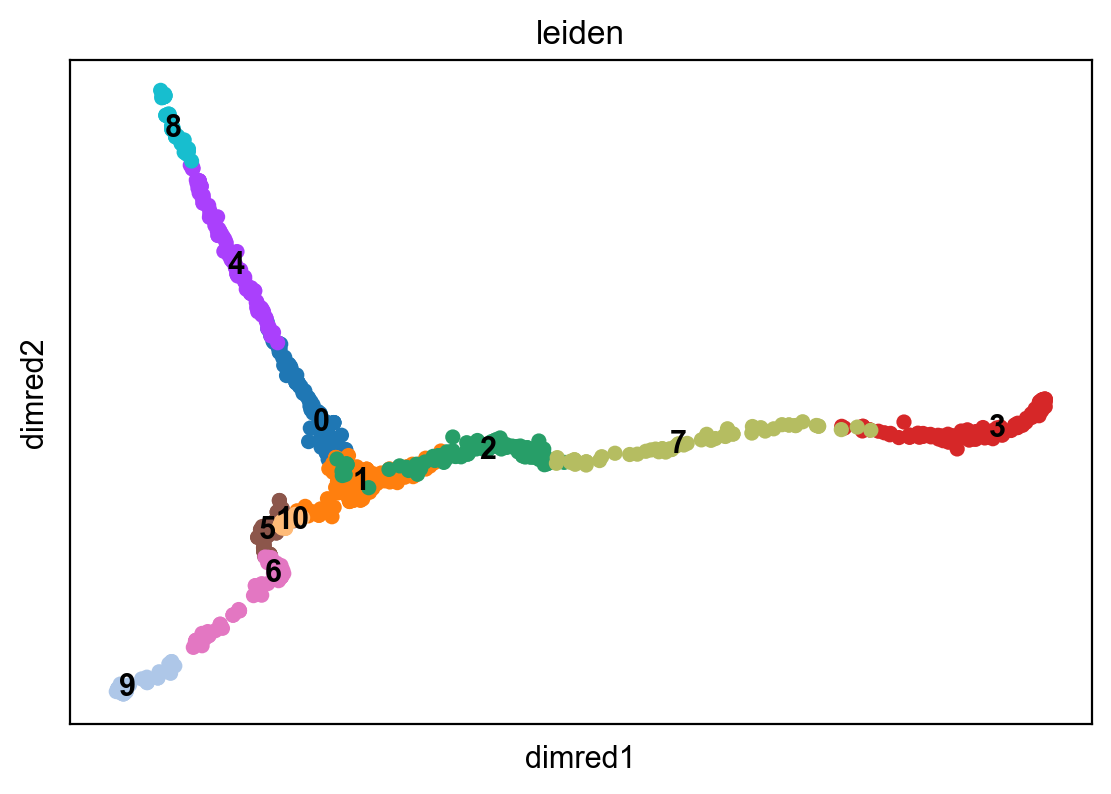

In [683]:
sc.pl.scatter(adata, color=['leiden'],basis="dimred",legend_loc='on data')

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


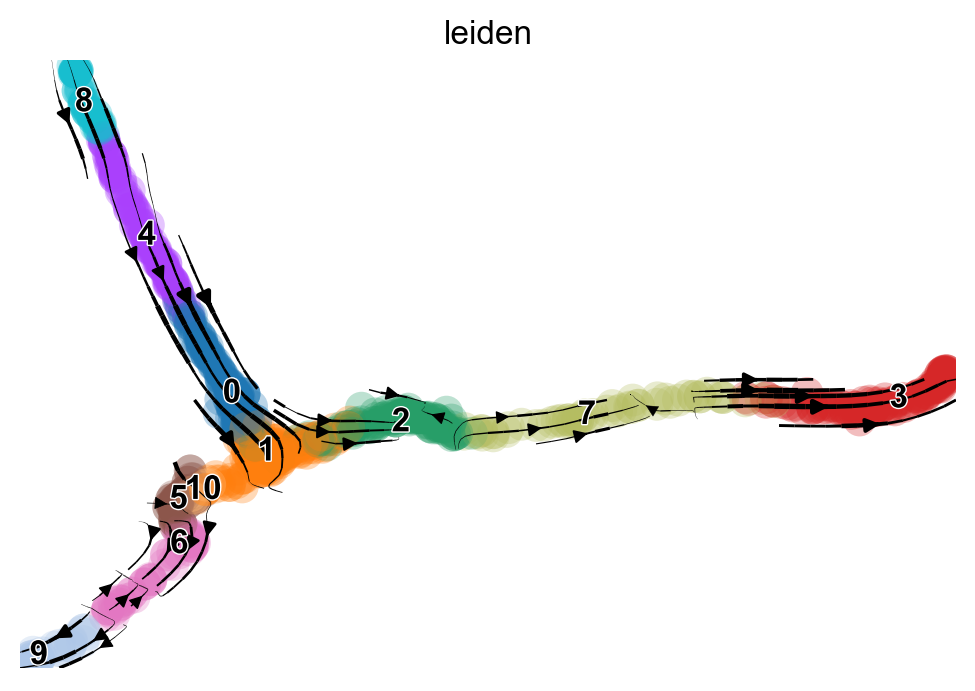

In [684]:
## Using ground truth velocity to predict cell fate
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis='dimred',color = 'leiden')

In [685]:
### running cellrank
import cellrank as cr

In [686]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()

  0%|          | 0/1000 [00:00<?, ?cell/s]

  0%|          | 0/1000 [00:00<?, ?cell/s]

VelocityKernel

In [687]:
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

In [688]:
combined_kernel = 0.2 * vk + 0.8 * ck

In [689]:
g = cr.estimators.GPCCA(combined_kernel)

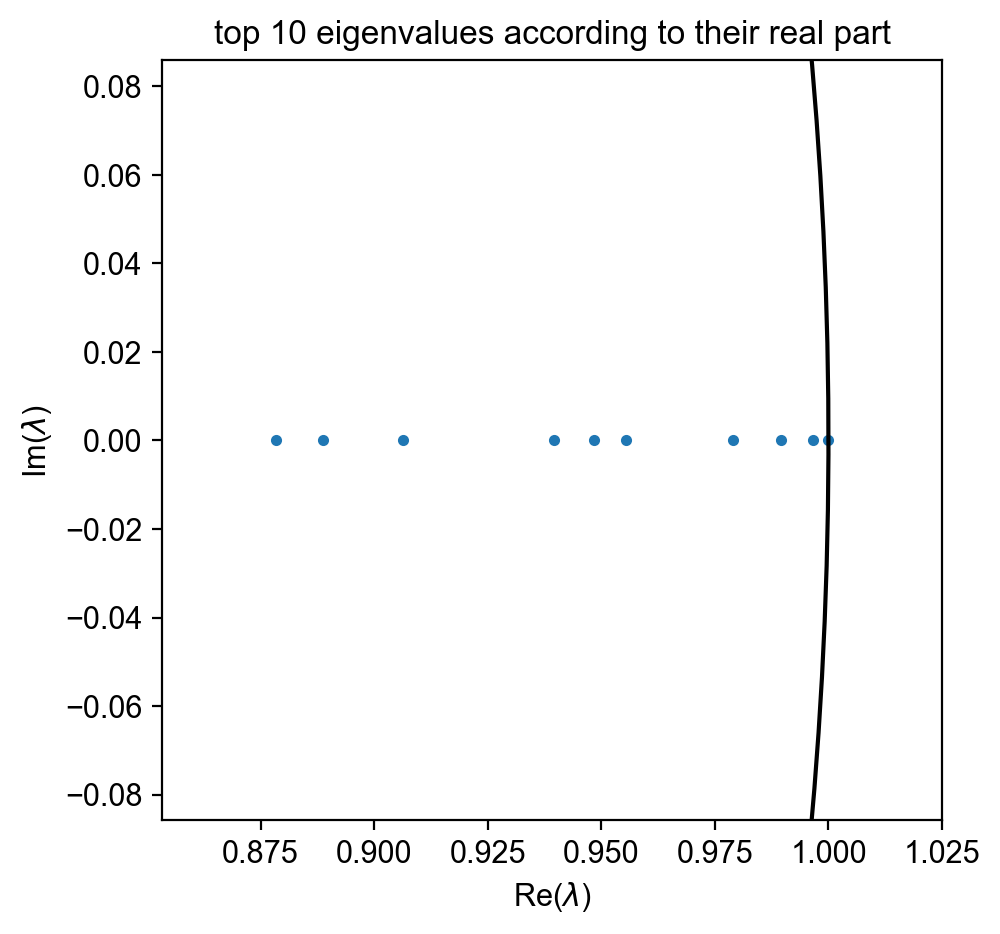

In [690]:
g.compute_schur(n_components=10,method='brandts')
g.plot_spectrum()

In [691]:
g.compute_macrostates(cluster_key="leiden")
g.set_terminal_states_from_macrostates(["3", "9"])

Using pre-computed Schur decomposition


In [692]:
g.compute_absorption_probabilities()

  0%|          | 0/2 [00:00<?, ?/s]

In [693]:
adata.obs["cell_fate_to_3"] = pd.DataFrame(g.absorption_probabilities).iloc[:,0].values
adata.obs["cell_fate_to_9"] = pd.DataFrame(g.absorption_probabilities).iloc[:,1].values

In [694]:
adata.obs

,step_ix,simulation_i,sim_time,initial_size_unspliced,initial_size_spliced,initial_size,n_counts,leiden,velocity_self_transition,terminal_states,terminal_states_probs,cell_fate_to_3,cell_fate_to_9
cell1,1795,4,0.000000,7562.0,97177.0,104739.0,280813.62500,8,0.336285,NaN,0.948817,0.385601,0.614368
cell2,2983,6,78.083333,12867.0,199599.0,212466.0,280813.62500,0,0.212542,NaN,0.917688,0.385570,0.614405
cell3,260,1,372.083333,19690.0,322862.0,342552.0,280813.53125,6,0.289816,NaN,0.971498,0.194426,0.805564
cell4,1308,3,172.000000,15353.0,209977.0,225330.0,280813.50000,1,0.354343,NaN,0.903545,0.385352,0.614626
cell5,1842,4,92.083333,17823.0,206054.0,223877.0,280813.46875,0,0.229054,NaN,0.917375,0.385628,0.614348
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell996,5414,10,348.083333,24459.0,285248.0,309707.0,280813.40625,2,0.302165,NaN,0.882322,0.400435,0.599543
cell997,4105,8,26.083333,9449.0,100082.0,109531.0,280808.37500,4,0.381848,NaN,0.933162,0.385597,0.614374
cell998,4097,8,10.000000,17909.0,194091.0,212000.0,280813.46875,8,0.254359,NaN,0.949011,0.385601,0.614368
cell999,1239,3,34.083333,9729.0,124767.0,134496.0,280813.53125,4,0.290901,NaN,0.933592,0.385605,0.614367


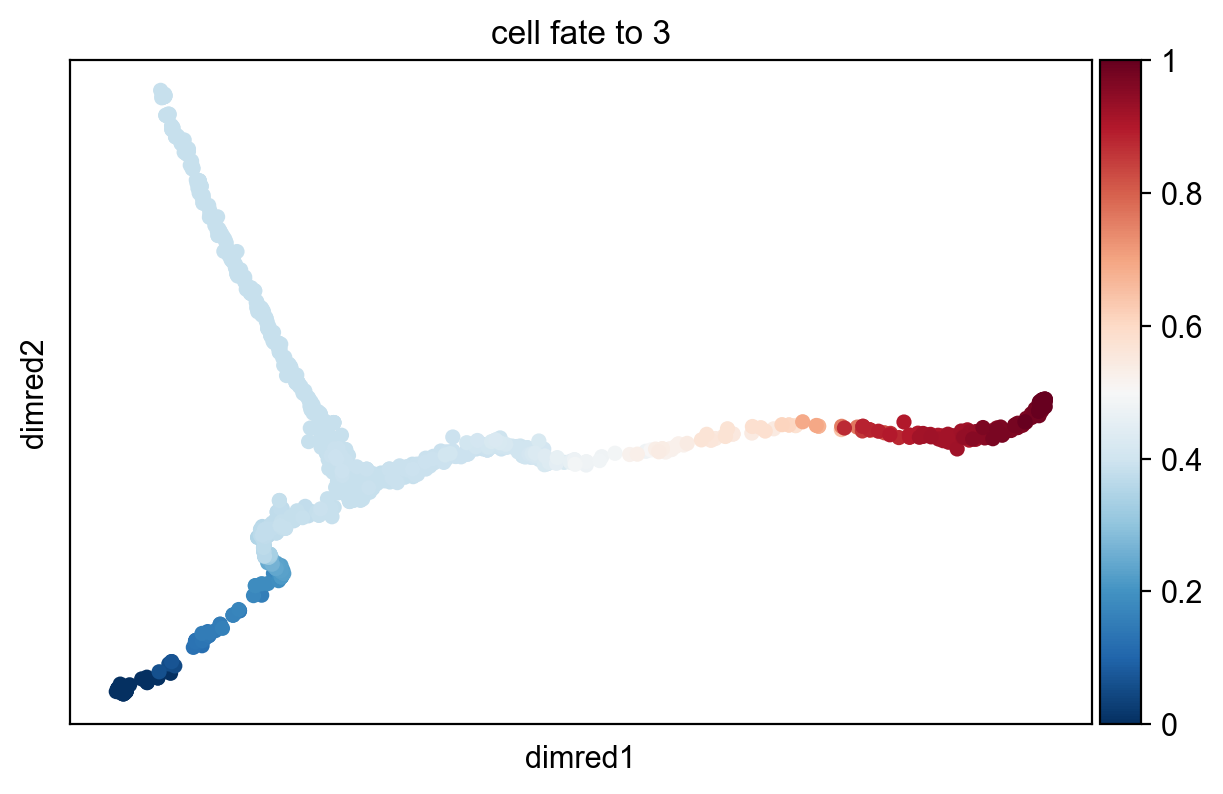

In [695]:
sc.pl.scatter(adata, color=['cell_fate_to_3'],basis="dimred")

In [696]:
### Using VeloVI to compute velocity
cluster = adata.obs["leiden"].copy()

In [697]:
### preprocessing
adata = sc.read_h5ad("dataset_branch_v2.h5ad")
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=280)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata.X = np.log1p(adata.X.copy())
adata = adata[:,indices].copy()
adata = preprocess_data(adata,filter_on_r2=False)
#adata = sanity_check(adata)
adata.uns["Ms"] = adata.layers["Ms"]
adata.uns["Mu"] = adata.layers["Mu"]

Filtered out 14 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [698]:
adata.obs["leiden"] = cluster.copy()
adata.obsm["X_dimred"] = adata.obsm["dimred"][:,:2].copy()

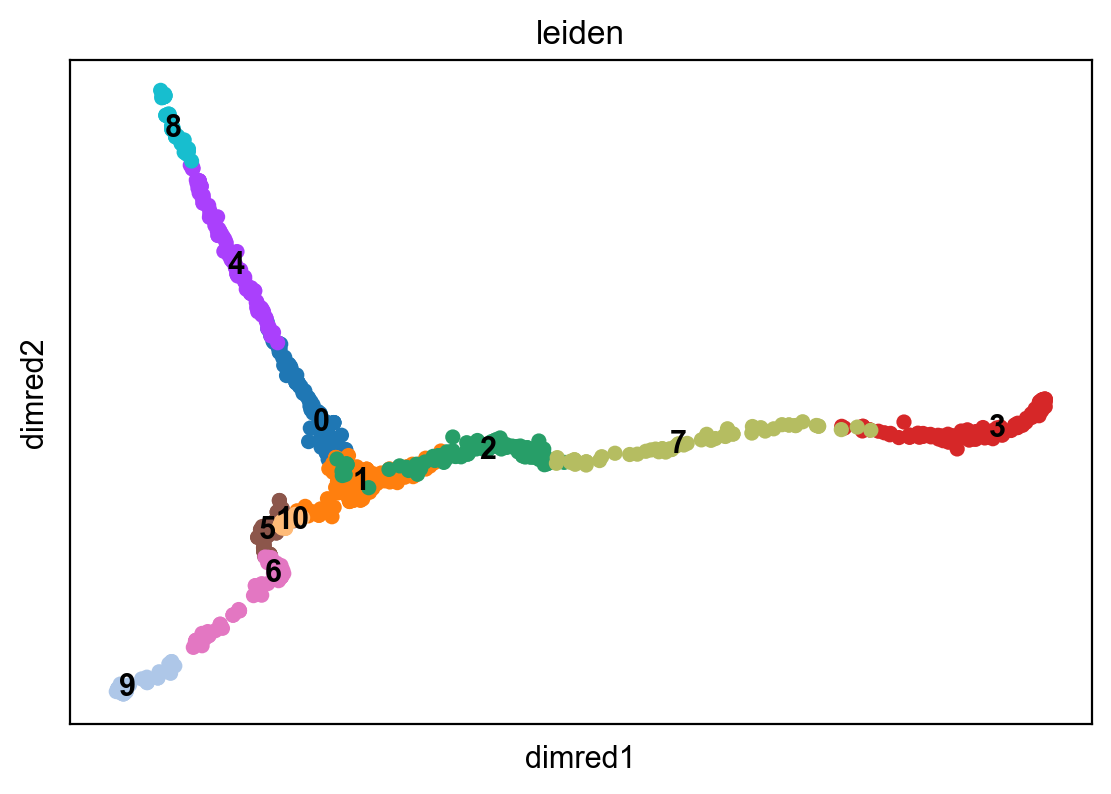

In [699]:
sc.pl.scatter(adata, color=['leiden'],basis="dimred",legend_loc='on data')

In [700]:
### calculate groundtruth cellfate
cellfate = pd.DataFrame(g.absorption_probabilities)

In [701]:
adata.layers["velocity"] = velocity_velovi.copy()
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()

  0%|          | 0/1000 [00:00<?, ?cell/s]

  0%|          | 0/1000 [00:00<?, ?cell/s]

VelocityKernel

In [702]:
combined_kernel = 0.2 * vk + 0.8 * ck

In [703]:
g = cr.estimators.GPCCA(combined_kernel)

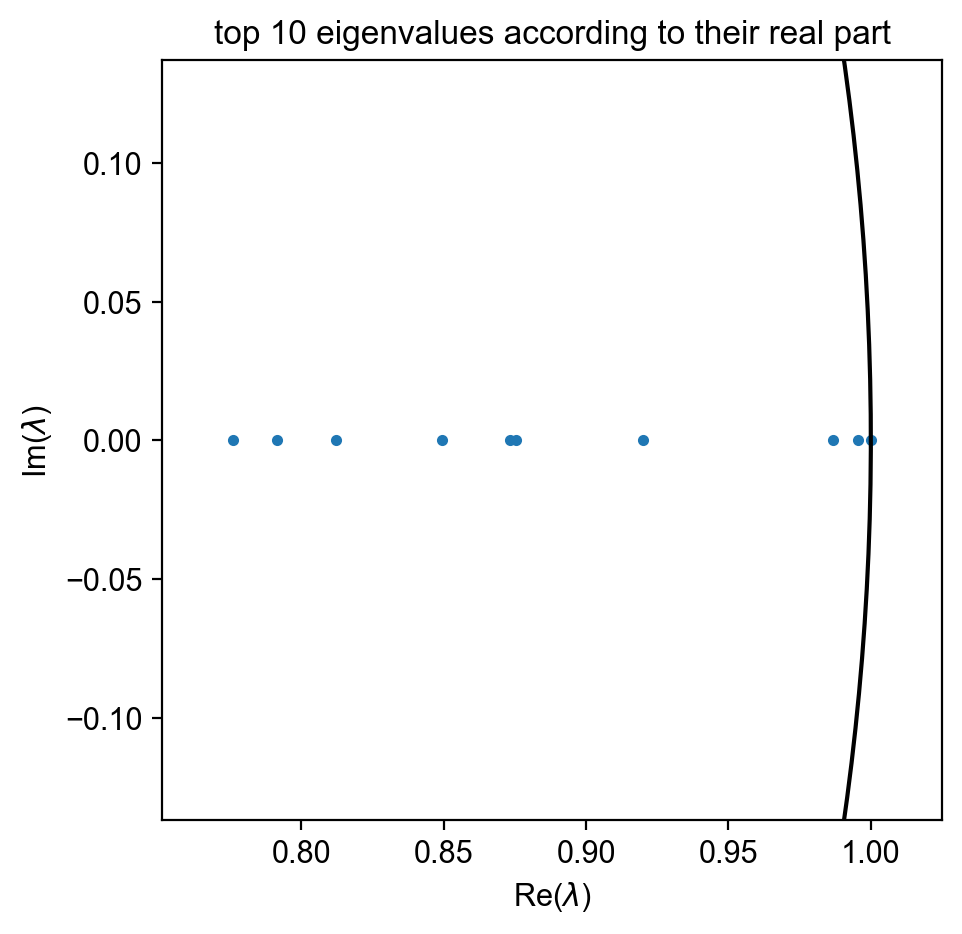

In [704]:
g.compute_schur(n_components=10,method='brandts')
g.plot_spectrum()

In [705]:
g.compute_macrostates(cluster_key="leiden")
g.set_terminal_states_from_macrostates(["3", "9"])

Using pre-computed Schur decomposition


In [706]:
g.compute_absorption_probabilities()

  0%|          | 0/2 [00:00<?, ?/s]

In [707]:
cellfate_velovi = pd.DataFrame(g.absorption_probabilities)

In [708]:
cellfate_velovi

,0,1
0,0.623787,0.376216
1,0.623779,0.376224
2,0.384386,0.615616
3,0.623193,0.376810
4,0.626384,0.373620
...,...,...
995,0.631318,0.368686
996,0.624372,0.375631
997,0.625184,0.374820
998,0.624754,0.375250


In [709]:
adata.obs["cell_fate_to_3"] = pd.DataFrame(g.absorption_probabilities).iloc[:,0].values
adata.obs["cell_fate_to_9"] = pd.DataFrame(g.absorption_probabilities).iloc[:,1].values

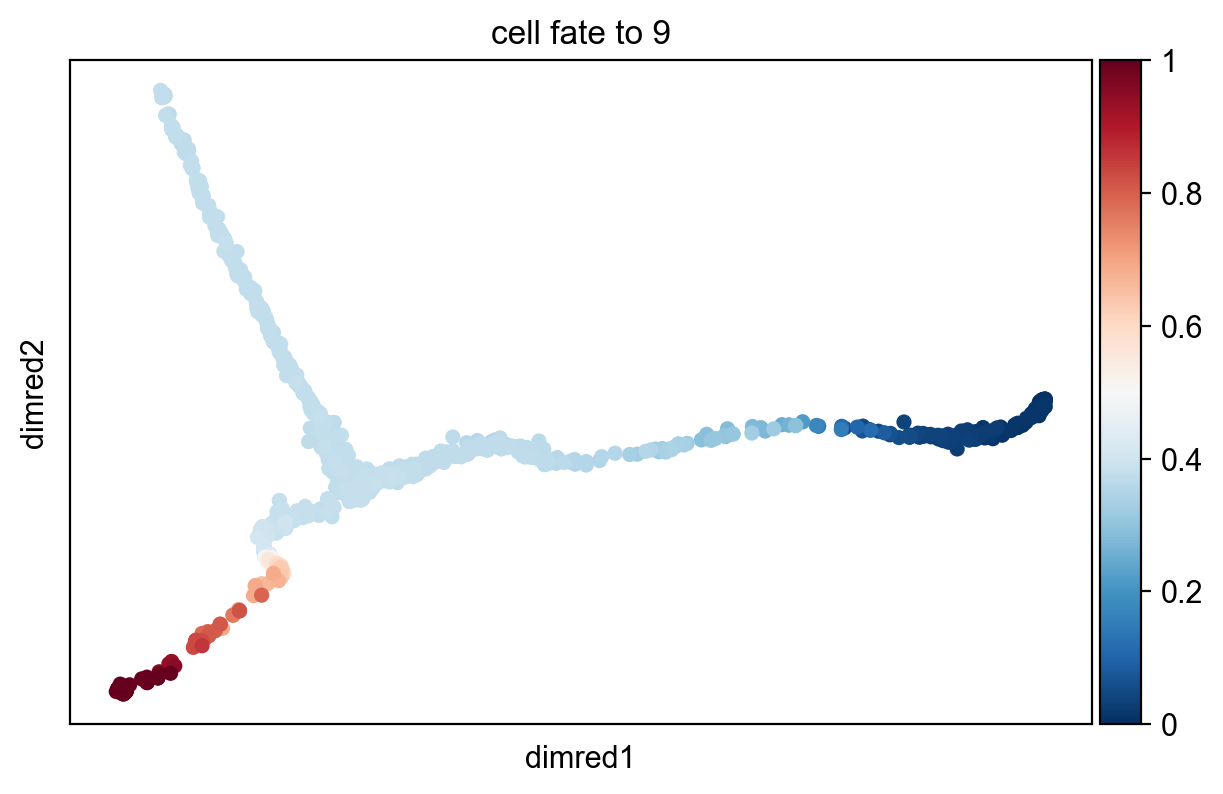

In [710]:
sc.pl.scatter(adata, color=['cell_fate_to_9'],basis="dimred")

In [711]:
corr1, _ = stats.spearmanr(cellfate_velovi.iloc[:,0].values,cellfate.iloc[:,0].values)
corr2, _ = stats.spearmanr(cellfate_velovi.iloc[:,1].values,cellfate.iloc[:,1].values)
print("corr to cell fate (cluster 3): "+str(corr1))
print("corr to cell fate (cluster 9): "+str(corr2))
corr_velovi = (corr1+corr2)/2

corr to cell fate (cluster 3): 0.9579520208840273
corr to cell fate (cluster 9): 0.9586556915436933


In [712]:
## benchmark dynamical
adata.layers["velocity"] = velocity_dynamics.copy()
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()

  0%|          | 0/1000 [00:00<?, ?cell/s]

  0%|          | 0/1000 [00:00<?, ?cell/s]

VelocityKernel

In [713]:
combined_kernel = 0.2 * vk + 0.8 * ck

In [714]:
g = cr.estimators.GPCCA(combined_kernel)

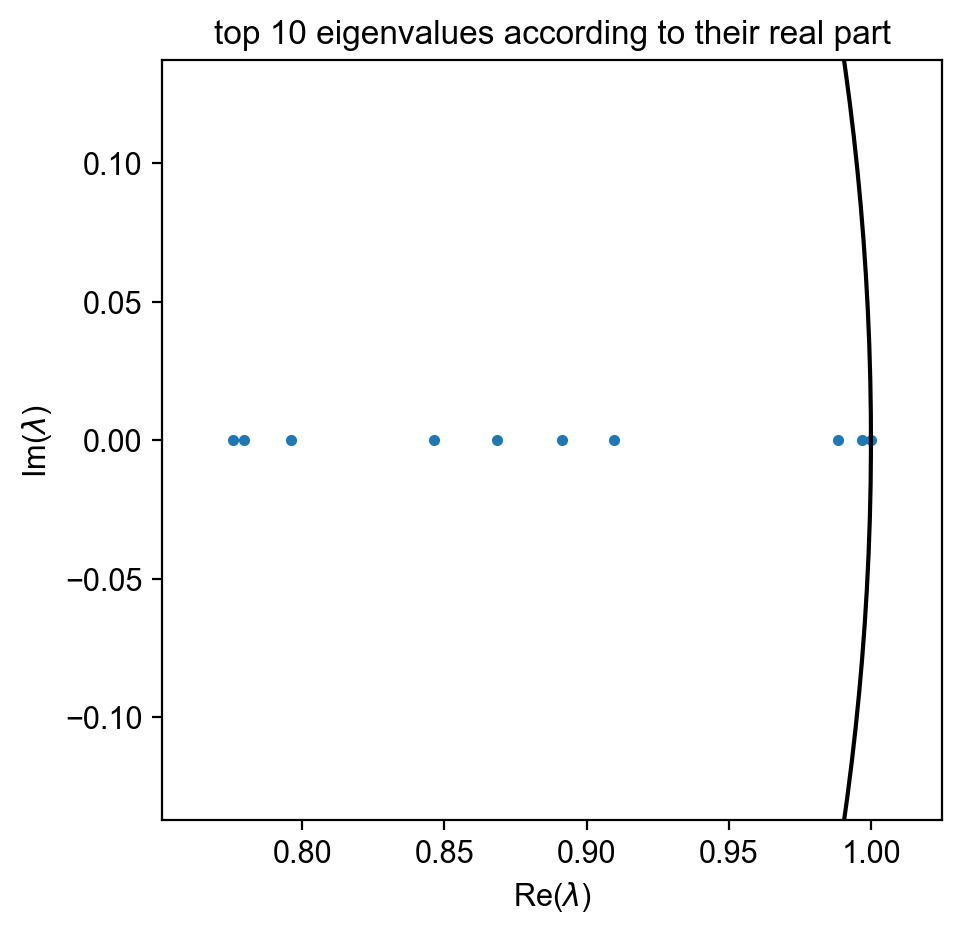

In [715]:
g.compute_schur(n_components=10,method='brandts')
g.plot_spectrum()

In [716]:
g.compute_macrostates(cluster_key="leiden")
g.set_terminal_states_from_macrostates(["3", "9"])

Using pre-computed Schur decomposition


In [717]:
g.compute_absorption_probabilities()

  0%|          | 0/2 [00:00<?, ?/s]

In [718]:
cellfate_velovi = pd.DataFrame(g.absorption_probabilities)

In [719]:
cellfate_velovi

,0,1
0,0.338289,0.661711
1,0.339570,0.660430
2,0.129546,0.870455
3,0.331884,0.668117
4,0.342071,0.657929
...,...,...
995,0.365132,0.634869
996,0.340469,0.659531
997,0.340895,0.659105
998,0.341549,0.658452


In [720]:
adata.obs["cell_fate_to_3"] = pd.DataFrame(g.absorption_probabilities).iloc[:,0].values
adata.obs["cell_fate_to_9"] = pd.DataFrame(g.absorption_probabilities).iloc[:,1].values

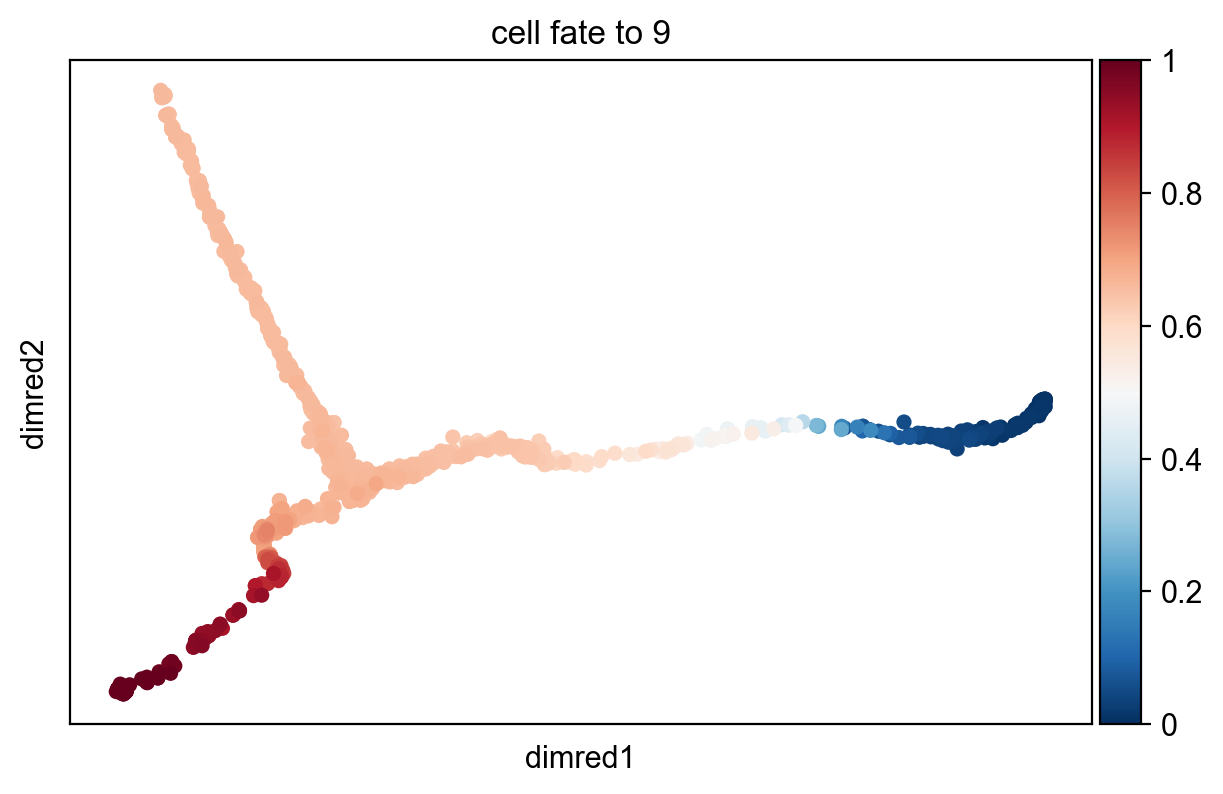

In [721]:
sc.pl.scatter(adata, color=['cell_fate_to_9'],basis="dimred")

In [722]:
corr1, _ = stats.spearmanr(cellfate_velovi.iloc[:,0].values,cellfate.iloc[:,0].values)
corr2, _ = stats.spearmanr(cellfate_velovi.iloc[:,1].values,cellfate.iloc[:,1].values)
print("corr to cell fate (cluster 3): "+str(corr1))
print("corr to cell fate (cluster 9): "+str(corr2))
corr_dynamical = (corr1+corr2)/2

corr to cell fate (cluster 3): 0.9591397441375429
corr to cell fate (cluster 9): 0.9593139337075177


In [723]:
## Benchmark stochastic mode
adata.layers["velocity"] = velocity_stochastic.copy()
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()

  0%|          | 0/1000 [00:00<?, ?cell/s]

  0%|          | 0/1000 [00:00<?, ?cell/s]

VelocityKernel

In [724]:
combined_kernel = 0.2 * vk + 0.8 * ck

In [725]:
g = cr.estimators.GPCCA(combined_kernel)

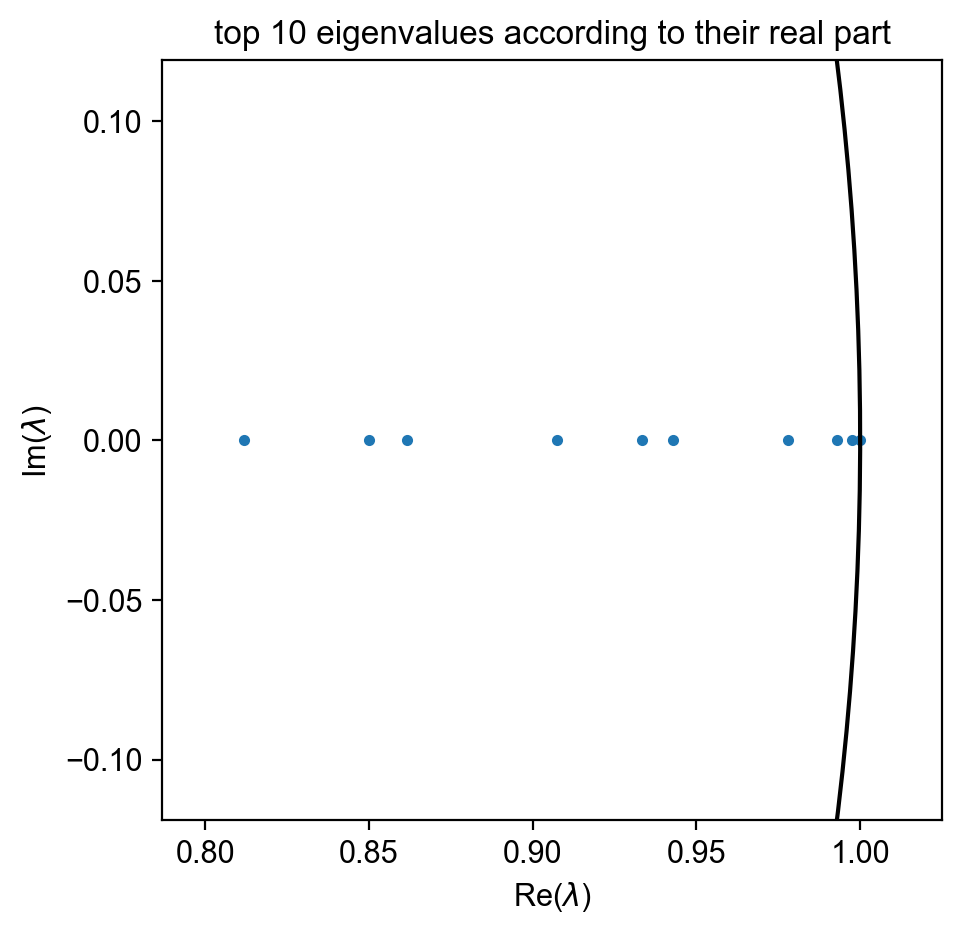

In [726]:
g.compute_schur(n_components=10,method='brandts')
g.plot_spectrum()

In [727]:
g.compute_macrostates(cluster_key="leiden")
g.set_terminal_states_from_macrostates(["3", "9"])

Using pre-computed Schur decomposition


In [728]:
g.compute_absorption_probabilities()

  0%|          | 0/2 [00:00<?, ?/s]

In [729]:
cellfate_velovi = pd.DataFrame(g.absorption_probabilities)

In [730]:
cellfate_velovi

,0,1
0,0.445428,0.554556
1,0.446967,0.553018
2,0.193363,0.806630
3,0.434842,0.565143
4,0.450001,0.549984
...,...,...
995,0.485671,0.514313
996,0.446909,0.553075
997,0.446062,0.553921
998,0.446948,0.553037


In [731]:
adata.obs["cell_fate_to_3"] = pd.DataFrame(g.absorption_probabilities).iloc[:,0].values
adata.obs["cell_fate_to_9"] = pd.DataFrame(g.absorption_probabilities).iloc[:,1].values

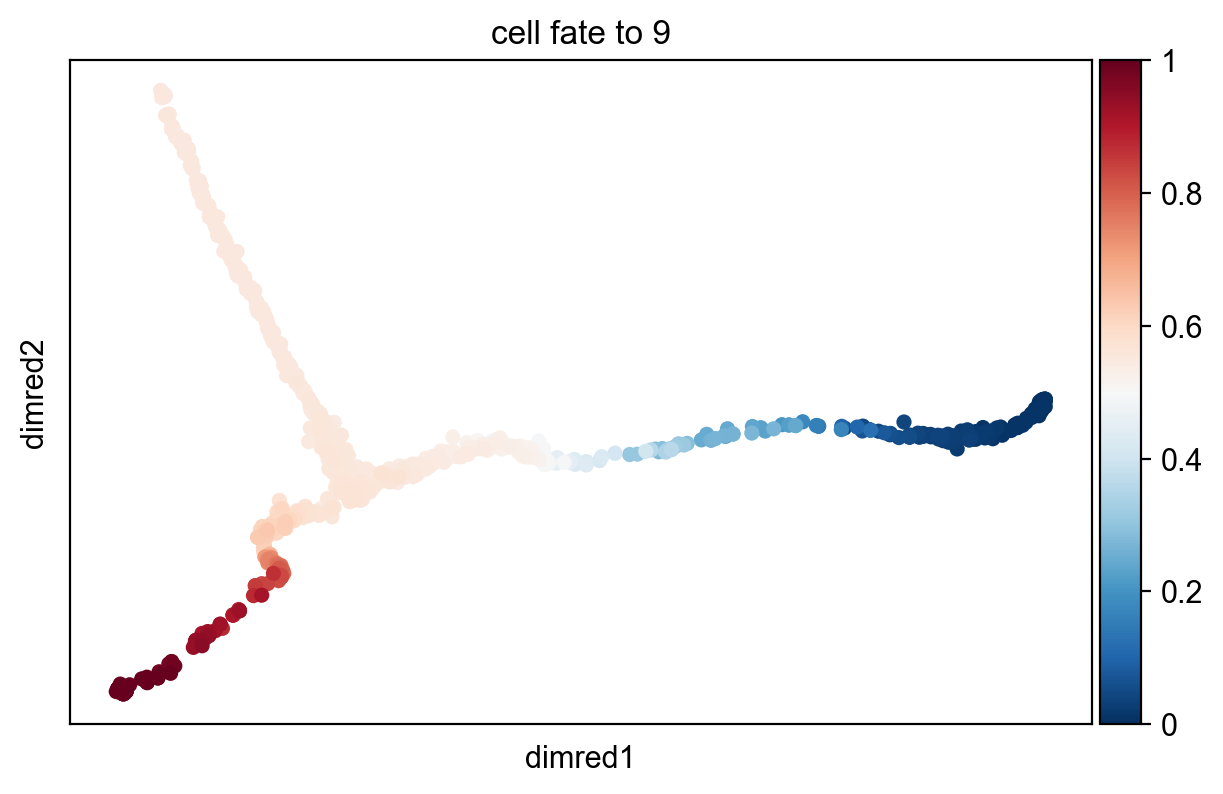

In [732]:
sc.pl.scatter(adata, color=['cell_fate_to_9'],basis="dimred")

In [733]:
corr1, _ = stats.spearmanr(cellfate_velovi.iloc[:,0].values,cellfate.iloc[:,0].values)
corr2, _ = stats.spearmanr(cellfate_velovi.iloc[:,1].values,cellfate.iloc[:,1].values)
print("corr to cell fate (cluster 3): "+str(corr1))
print("corr to cell fate (cluster 9): "+str(corr2))
corr_stochastic = (corr1+corr2)/2

corr to cell fate (cluster 3): 0.9666658406212837
corr to cell fate (cluster 9): 0.9661453480254205


In [734]:
### Benchmark deterministic
adata.layers["velocity"] = velocity_deterministic.copy()
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()

  0%|          | 0/1000 [00:00<?, ?cell/s]

  0%|          | 0/1000 [00:00<?, ?cell/s]

VelocityKernel

In [735]:
combined_kernel = 0.2 * vk + 0.8 * ck

In [736]:
g = cr.estimators.GPCCA(combined_kernel)

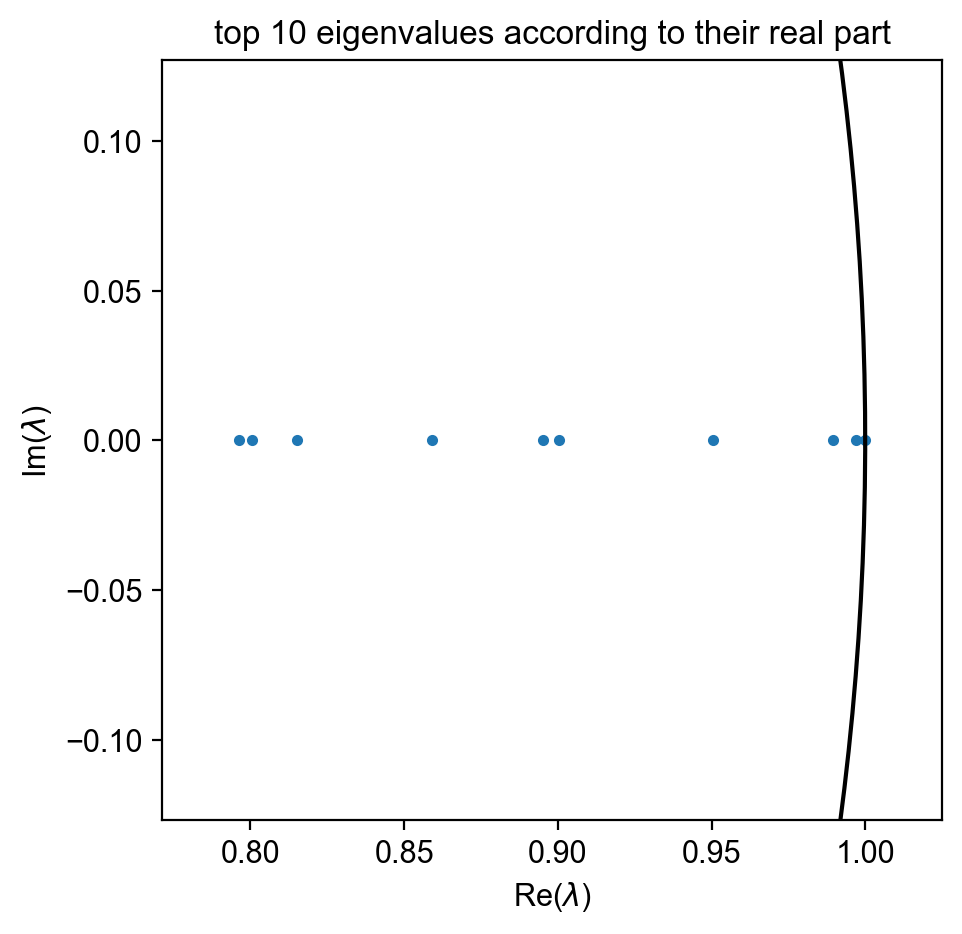

In [737]:
g.compute_schur(n_components=10,method='brandts')
g.plot_spectrum()

In [738]:
g.compute_macrostates(cluster_key="leiden")
g.set_terminal_states_from_macrostates(["3", "9"])

Using pre-computed Schur decomposition


In [739]:
g.compute_absorption_probabilities()

  0%|          | 0/2 [00:00<?, ?/s]

In [740]:
cellfate_velovi = pd.DataFrame(g.absorption_probabilities)

In [741]:
cellfate_velovi

,0,1
0,0.310950,0.689032
1,0.310460,0.689524
2,0.125885,0.874110
3,0.306571,0.693415
4,0.313913,0.686071
...,...,...
995,0.336242,0.663743
996,0.311608,0.688375
997,0.313316,0.686665
998,0.312050,0.687933


In [742]:
adata.obs["cell_fate_to_3"] = pd.DataFrame(g.absorption_probabilities).iloc[:,0].values
adata.obs["cell_fate_to_9"] = pd.DataFrame(g.absorption_probabilities).iloc[:,1].values

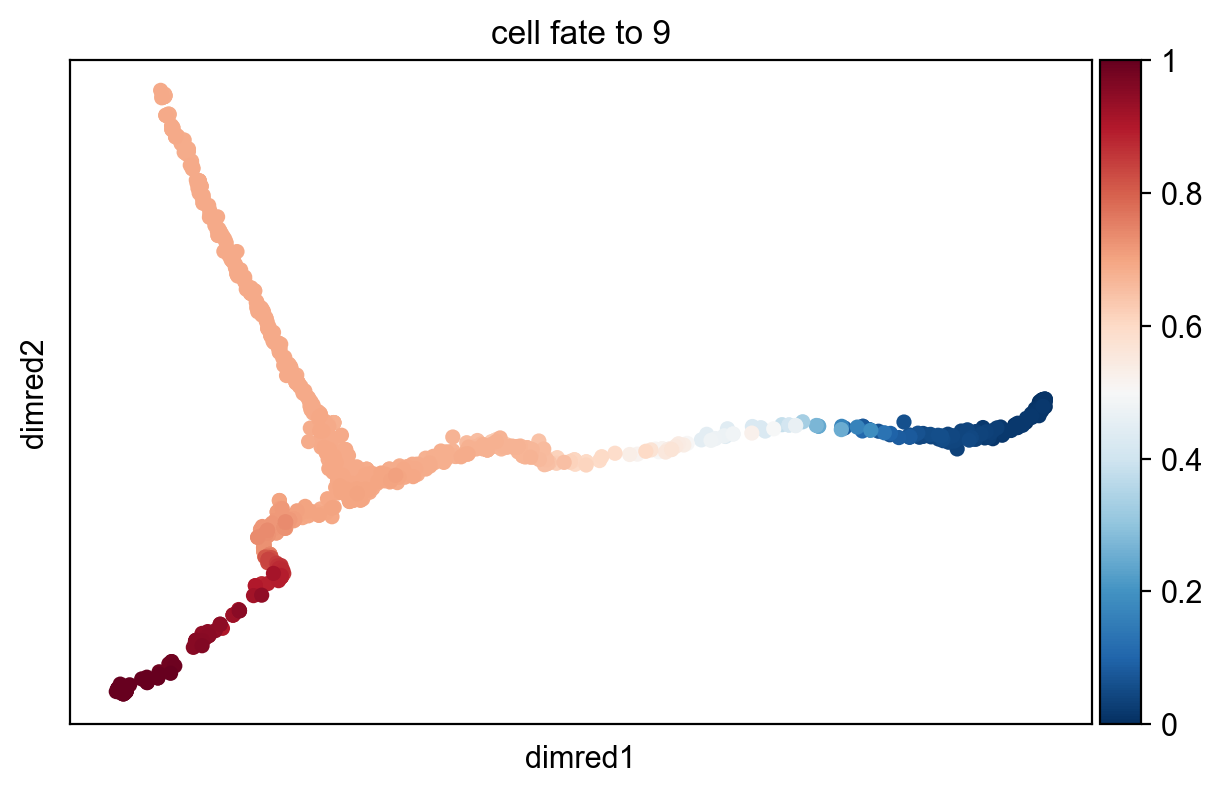

In [743]:
sc.pl.scatter(adata, color=['cell_fate_to_9'],basis="dimred")

In [744]:
corr1, _ = stats.spearmanr(cellfate_velovi.iloc[:,0].values,cellfate.iloc[:,0].values)
corr2, _ = stats.spearmanr(cellfate_velovi.iloc[:,1].values,cellfate.iloc[:,1].values)
print("corr to cell fate (cluster 3): "+str(corr1))
print("corr to cell fate (cluster 9): "+str(corr2))
corr_deterministic = (corr1+corr2)/2

corr to cell fate (cluster 3): 0.9619449942579845
corr to cell fate (cluster 9): 0.9627610390914876


#### using regvelo prediction to compare the performance

In [745]:
adata.layers["velocity"] = velocity_regvelovi.copy()
vk = cr.kernels.VelocityKernel(adata_target)
vk.compute_transition_matrix()

  0%|          | 0/1000 [00:00<?, ?cell/s]

  0%|          | 0/1000 [00:00<?, ?cell/s]

VelocityKernel

In [746]:
combined_kernel = 0.2 * vk + 0.8 * ck

In [747]:
g = cr.estimators.GPCCA(combined_kernel)

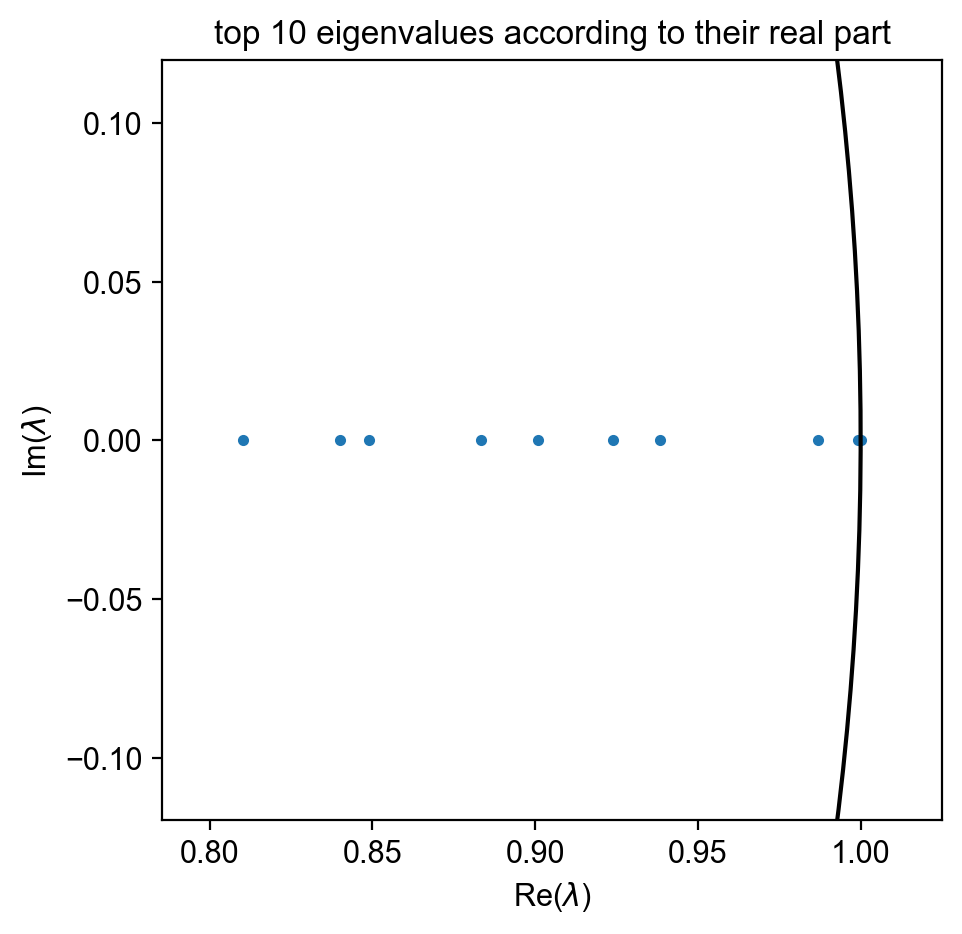

In [748]:
g.compute_schur(n_components=10,method='brandts')
g.plot_spectrum()

In [749]:
g.compute_macrostates(cluster_key="leiden")
g.set_terminal_states_from_macrostates(["3", "9"])

Using pre-computed Schur decomposition


In [750]:
g.compute_absorption_probabilities()

  0%|          | 0/2 [00:00<?, ?/s]

In [751]:
cellfate_velovi = pd.DataFrame(g.absorption_probabilities)

In [752]:
cellfate_velovi

,0,1
0,0.576195,0.423809
1,0.580017,0.419986
2,0.090364,0.909637
3,0.553352,0.446651
4,0.592070,0.407934
...,...,...
995,0.657509,0.342494
996,0.584570,0.415434
997,0.582497,0.417506
998,0.584857,0.415147


In [753]:
adata.obs["cell_fate_to_3"] = pd.DataFrame(g.absorption_probabilities).iloc[:,0].values
adata.obs["cell_fate_to_9"] = pd.DataFrame(g.absorption_probabilities).iloc[:,1].values

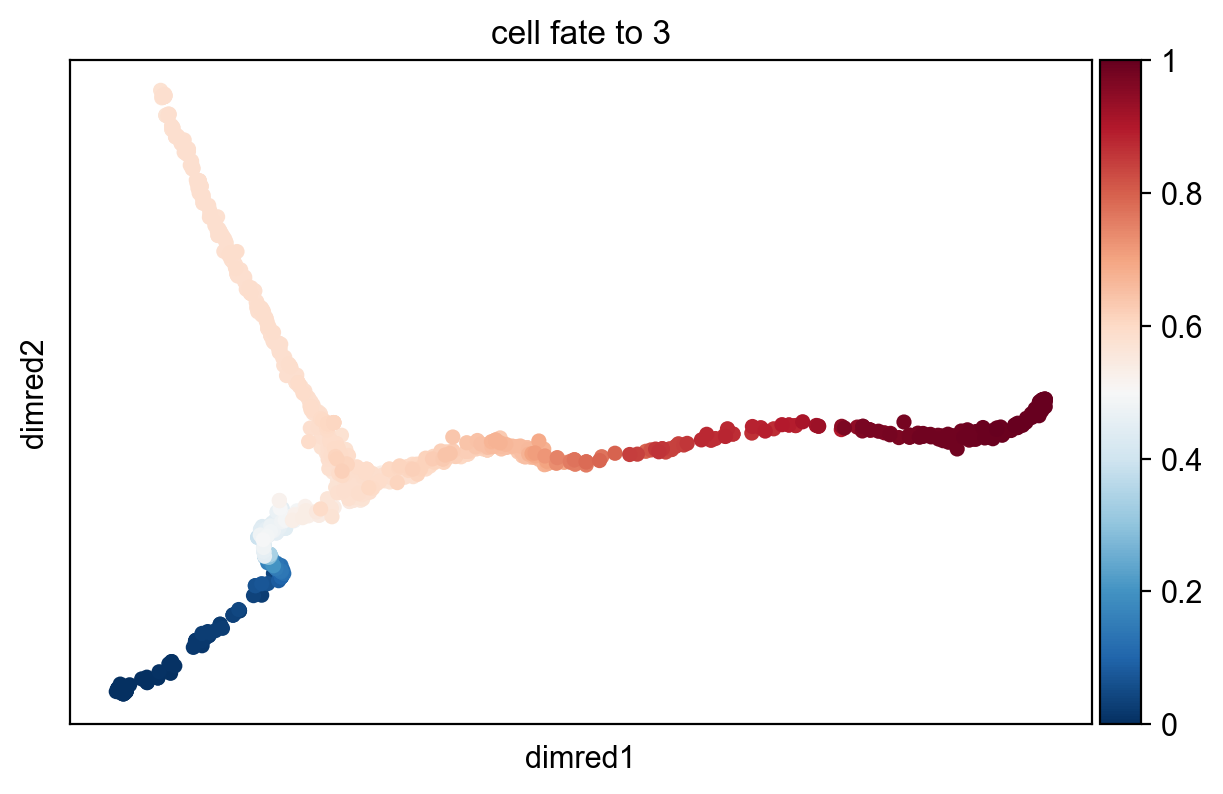

In [754]:
sc.pl.scatter(adata, color=['cell_fate_to_3'],basis="dimred")

In [755]:
corr1, _ = stats.spearmanr(cellfate_velovi.iloc[:,0].values,cellfate.iloc[:,0].values)
corr2, _ = stats.spearmanr(cellfate_velovi.iloc[:,1].values,cellfate.iloc[:,1].values)
print("corr to cell fate (cluster 3): "+str(corr1))
print("corr to cell fate (cluster 9): "+str(corr2))
corr_regvelovi = (corr1+corr2)/2

corr to cell fate (cluster 3): 0.9651438270018553
corr to cell fate (cluster 9): 0.964896373406755


In [771]:
d = {'Spearman_Correlation': [corr_regvelovi.mean(), 
              corr_velovi.mean(),
              corr_dynamical.mean(),
              corr_stochastic.mean(),
              corr_deterministic.mean()], 
     'Model': ["RegVeloVI", "VeloVI", "Dynamical", "Stochastic", "Deterministic"]}
df = pd.DataFrame(data=d)

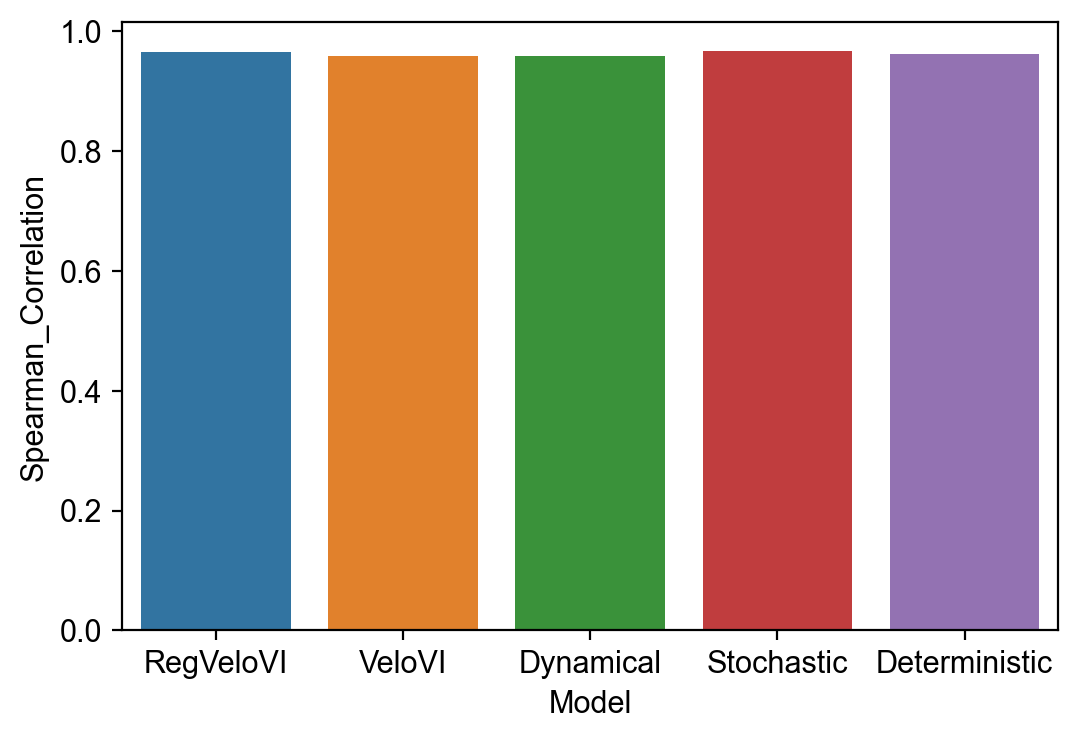

In [772]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(x="Model", y="Spearman_Correlation", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [773]:
d = {'Spearman_Correlation': [0.8604915334130934, 
              0.830956590572501,
              0.5628882821614195], 
     'Model': ["RegVeloVI", "VeloVI", "Stochastic"]}
df = pd.DataFrame(data=d)

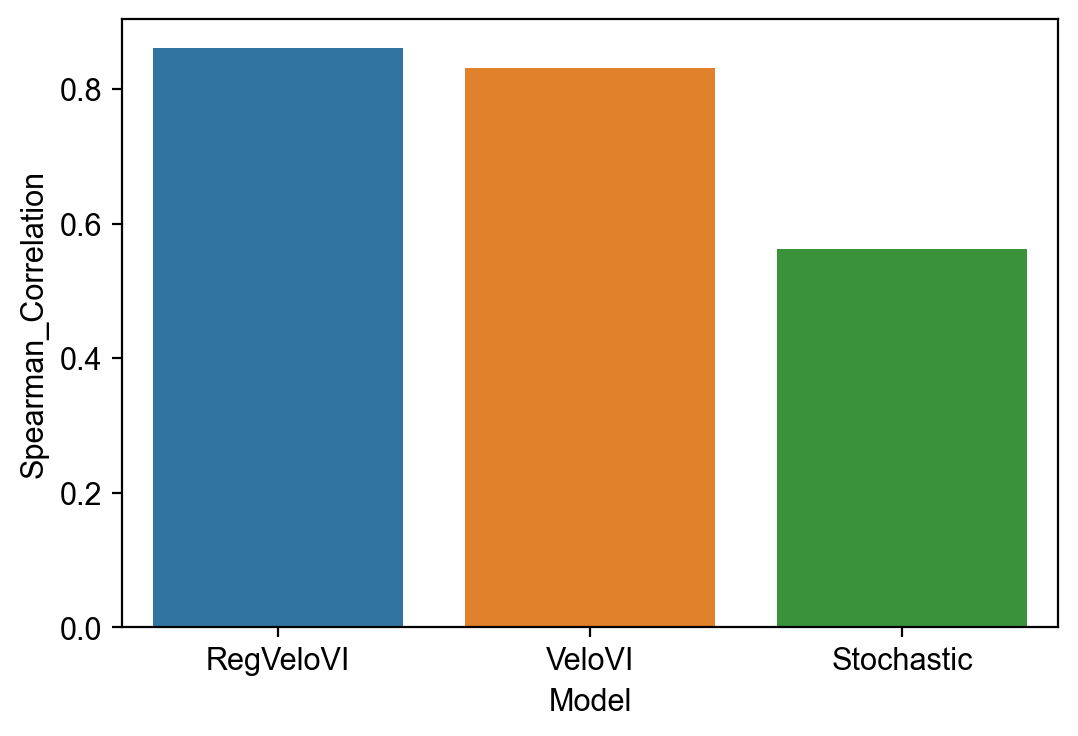

In [774]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(x="Model", y="Spearman_Correlation", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [5]:
import pandas as pd
import scvelo as scv
scv.set_figure_params()
d = {'Spearman_Correlation': [0.5383518277505851, 
              0.525184770420012,
              0.4557060765016458,
              0.047144231872399724,
              0.36242387183720415,
              0.38469482605232014,
              0.17966534482659777], 
     'Model': ["RegVeloVI(Cor)","RegVelo(CellOracle)","RegVelo(GRNBoost2)","RegVeloVI(random)","GRNBoost2(SCENIC)", "CellOracle","Pearsonr(Init)"]}
df = pd.DataFrame(data=d)

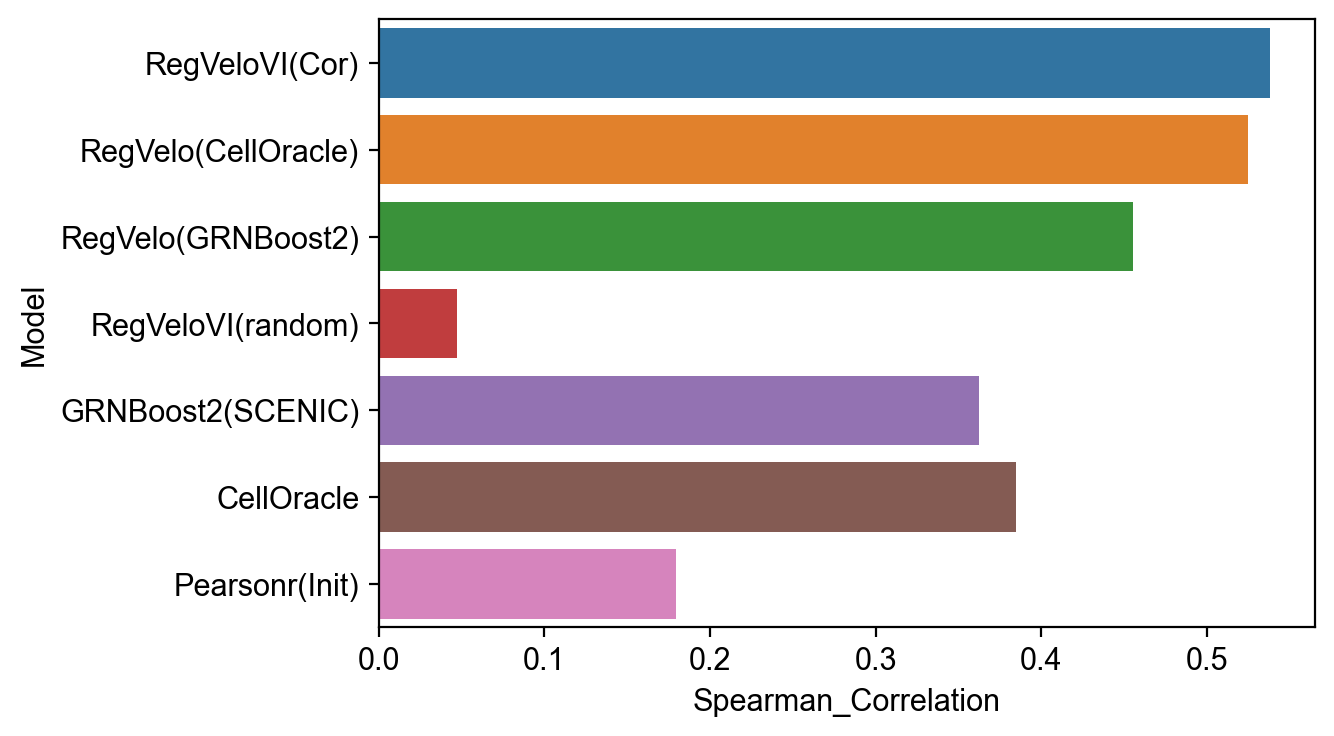

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(y="Model", x="Spearman_Correlation", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [118]:
d = {'AUROC': [0.7885602465511858, 
              0.7330168734841195,
              0.6808473503163835],
     'Model': ["RegVeloVI(full)","GRNBoost2(SCENIC)","Pearsonr(Init)"]}
df = pd.DataFrame(data=d)

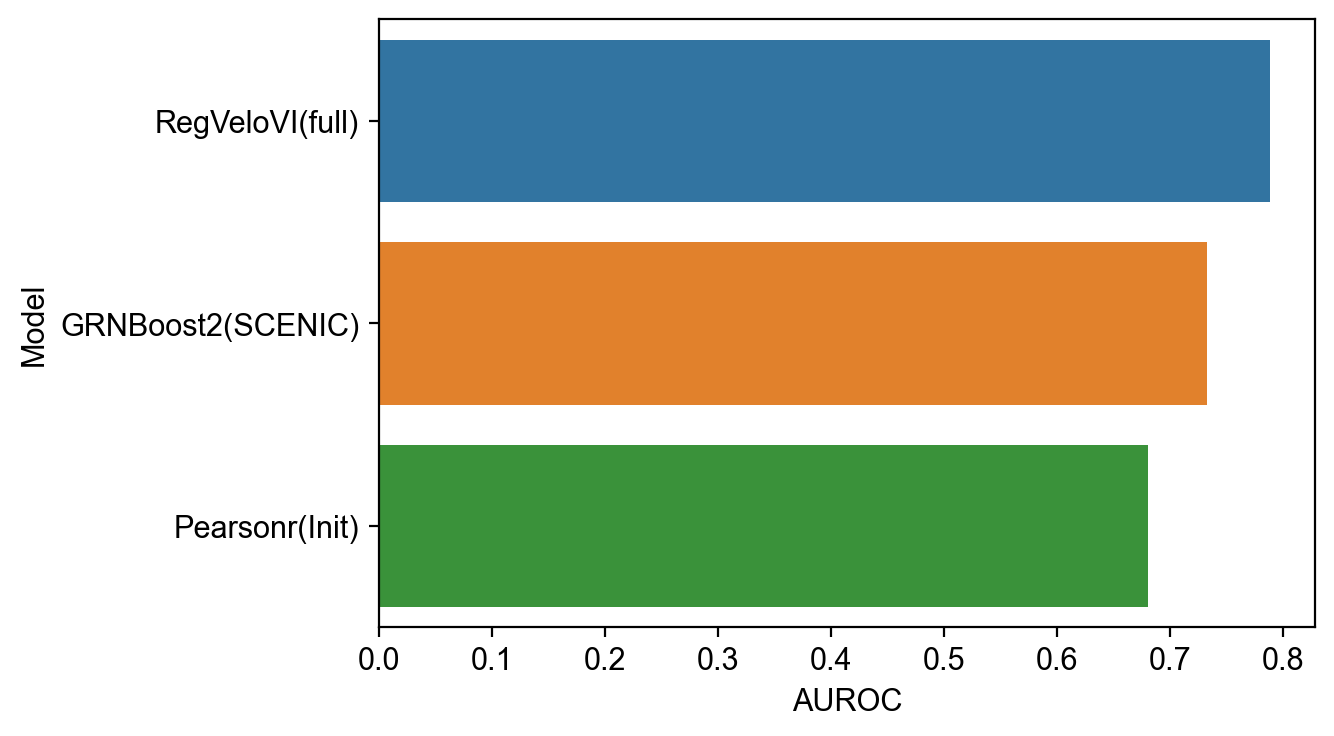

In [119]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(y="Model", x="AUROC", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [121]:
d = {'AUPRC': [0.7283105673907899, 
              0.08291278911721325,
              0.07205344569090064],
     'Model': ["RegVeloVI(full)","GRNBoost2(SCENIC)","Pearsonr(Init)"]}
df = pd.DataFrame(data=d)

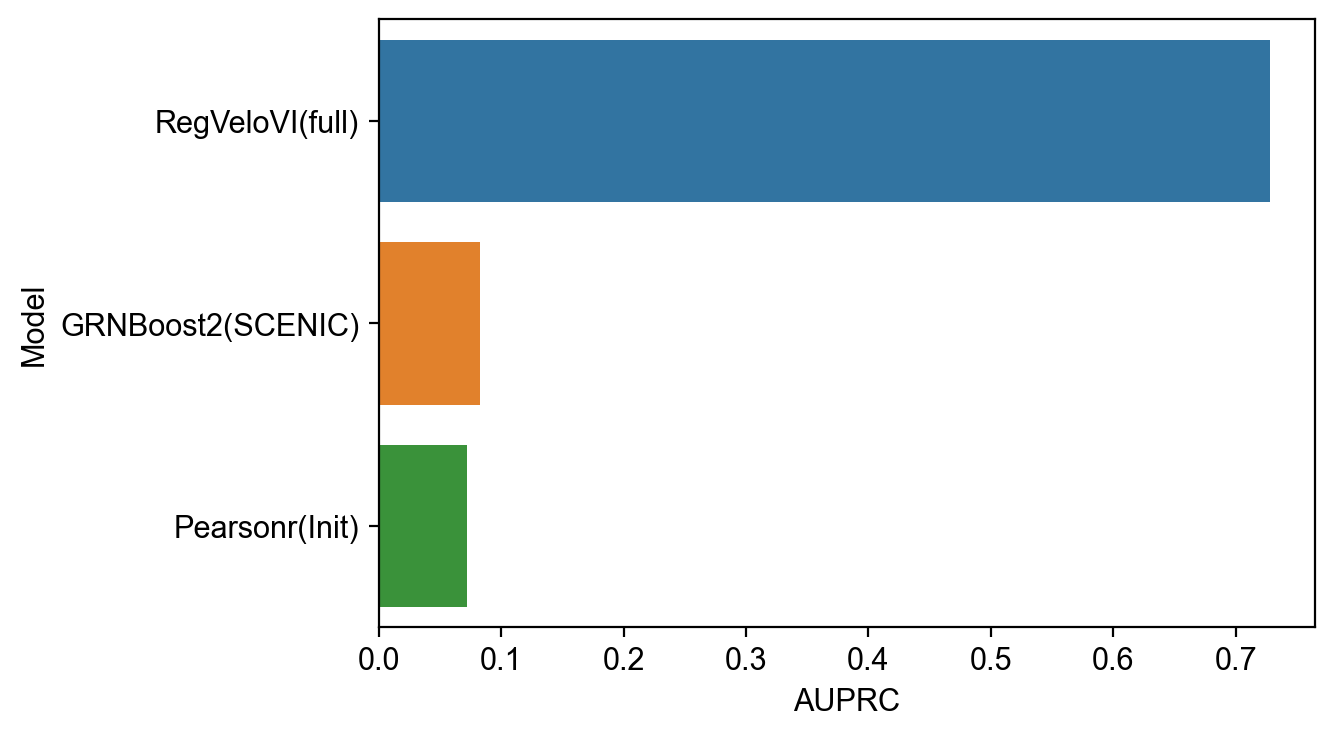

In [122]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(y="Model", x="AUPRC", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()